# Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.17
fastai     : 2.3.1
fastcore   : 1.3.19
torch      : 1.8.1+cu111


In [3]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker

In [5]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
           'legend.fontsize': med,
           'figure.figsize': (10, 6),
           'axes.labelsize': med,
           'axes.titlesize': med,
           'xtick.labelsize': med,
           'ytick.labelsize': med,
           'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)
print(sns.__version__)

3.3.2
0.11.0


In [6]:
import hyperopt
print(hyperopt.__version__)
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp
from hyperopt import space_eval

0.2.5


In [7]:
import time
from fastai.callback.tracker import EarlyStoppingCallback
import gc

In [8]:
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Specify parameters

In [9]:
file_name = "../OD_pair/CERNET-OD_pair.csv"  # the input filename
history = 10  # input historical time steps
horizon = 1  # output predicted time steps
test_ratio = 0.2  # testing data ratio
max_evals = 100  # maximal trials for hyper parameter tuning

model_name = 'TCN'
y_true_fn = '%s_true_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)
y_pred_fn = '%s_pred_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)

RMSE_fn = model_name + '_TM-minmax_RMSE-%d-%d-step-%d.pdf'
MAE_fn = model_name + '_TM-minmax_MAE-%d-%d-step-%d.pdf'

In [10]:
y_true_fn

'TCN_true_TM-minmax-10-1.pkl'

In [11]:
y_pred_fn

'TCN_pred_TM-minmax-10-1.pkl'

# Load data

In [12]:
df = pd.read_csv(file_name)

In [13]:
df.head()

time        OD_1-1       OD_1-2        OD_1-3        OD_1-4  \
0  2013-02-19-22-10  3.897921e+06  3660.257162  2.038509e+06  54492.199769   
1  2013-02-19-22-15  3.714310e+06  4102.475155  2.010658e+06  44398.935617   
2  2013-02-19-22-20  3.824844e+06  3475.827556  2.022040e+06  39446.603085   
3  2013-02-19-22-25  3.967014e+06  3616.911661  2.005270e+06  42316.578675   
4  2013-02-19-22-30  3.708735e+06  3464.036062  2.017856e+06  44239.873981   

          OD_1-5         OD_1-6         OD_1-7         OD_1-8        OD_1-9  \
0  234230.295946   84819.101740  326551.951138   70567.750666  12520.192382   
1  200445.246659  118932.827733  345145.938997   73246.388000  13969.378085   
2  191539.466968  143379.788071  380456.462916   88085.648186  13683.572258   
3  171440.464195  139779.197759  399477.041689  100997.455279  13928.180880   
4  150425.682249  134512.997369  388659.765735   95906.154986  12303.793875   

   ...  OD_14-5  OD_14-6   OD_14-7      OD_14-8  OD_14-9      OD_14-10  \
0  ...      0.0      0.0  0.000000  1381.832533      0.0  10897.764534   
1  ...      0.0      0.0  0.000000  1123.647467      0.0  10333.189333   
2  ...      0.0      0.0  0.000000  1430.037600      0.0   9900.663200   
3  ...      0.0      0.0  0.000000  1954.184000      0.0  10663.956267   
4  ...      0.0      0.0  0.083324  3102.597333      0.0   7687.432800   

   OD_14-11      OD_14-12  OD_14-13  OD_14-14  
0       0.0  36048.613333       0.0       0.0  
1       0.0  32883.840000       0.0       0.0  
2       0.0  28923.253333       0.0       0.0  
3       0.0  34839.440000       0.0       0.0  
4       0.0  35943.493333       0.0       0.0  

[5 rows x 197 columns]

Parse the time column:

In [14]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d-%H-%M')  # Parse the time

Remove the outliers:

In [15]:
data_columns = list(df.columns.values)
data_columns.remove('time')
data = df[data_columns].values
# data = np.clip(data, 0.0, np.percentile(data.flatten(), 99))  # we use 99% as the threshold
# df[data_columns] = data

# Split the data

Split the data based on the test_ratio parameter. Aggreate the data and plot the training/testing split first:

In [16]:
aggregated_time_series = np.sum(data, axis=1)
df_ts = pd.DataFrame()
df_ts['date'] = df['time']
df_ts['data'] = aggregated_time_series / 1000  # Plot in Mbps

# add a datetimeindex
dates = pd.DatetimeIndex(df_ts['date'])
df_ts = df_ts.set_index(dates).asfreq('5T') 

In [17]:
test_length = int(df.shape[0] * test_ratio)
train_length = df.shape[0] - test_length

In [18]:
df_ts.index[train_length:][0]

Timestamp('2013-03-19 16:50:00', freq='5T')

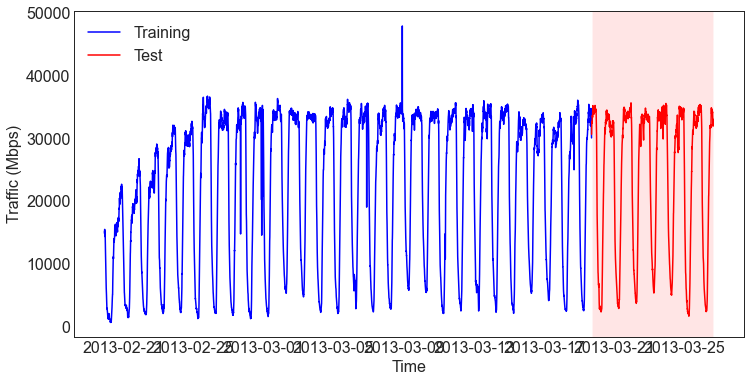

In [19]:
plt.figure(figsize=[12, 6])
plt.plot(df_ts.index[:train_length], df_ts['data'][:train_length], label='Training', color='blue')
plt.plot(df_ts.index[train_length:], df_ts['data'][train_length:], label='Test', color='red')
plt.axvspan(df_ts.index[train_length:][0], df_ts.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend(loc='best')
# plt.show()
plt.savefig('training_test_split.pdf', bbox_inches = 'tight', pad_inches = 0.1)

Plot the training / testing split:

# Normalize the data

Calculate the min and max data based on the training data set:

In [20]:
max_list = np.max(data[:train_length], axis=0)

In [21]:
min_list = np.min(data[:train_length], axis=0)

Normalize the data and fill the data:

In [22]:
data = (data - min_list) / (max_list - min_list)
data[np.isnan(data)] = 0  # fill the abnormal data with 0
data[np.isinf(data)] = 0

In [23]:
print(np.max(data[:train_length].flatten()))

1.0


In [24]:
print(np.min(data[:train_length].flatten()))

0.0


The training data is in a range of [0, 1] but the test data may be out of this range:

In [25]:
print(np.max(data.flatten()))

2.0845760812827483


In [26]:
print(np.min(data.flatten()))

-0.004873735825012876


# Build the supervised prediction problem

The input data is in the following format:
* x_data as input features: [data size, input historical steps, input channels]. Here the input channel number is the OD pair number.
* y_data as output targets: [data size, output prediction steps, output channels].

In [27]:
x_data = []
y_data = []

In [28]:
length = data.shape[0]
print(length)

9999


In [29]:
for i in range(length - history - horizon + 1):
    x = data[i:i+history, :]  # input historical time steps
    y = data[i+history:i+history+horizon:, :]  # output predicted time steps
    x_data.append(x)
    y_data.append(y)

In [30]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [31]:
x_data.shape

(9989, 10, 196)

In [32]:
y_data.shape

(9989, 1, 196)

Reshape x_data:

In [33]:
x_data = np.swapaxes(x_data, 1, 2)

Reshape y_data:

In [34]:
y_data = y_data.reshape(y_data.shape[0], -1)
y_data.shape

(9989, 196)

The last test_length samples are fixed as test data. The training data size may vary with the input historical time steps. The test data size may vary with the prediction horizon.

In [35]:
test_length = test_length - horizon + 1

In [36]:
train_valid_length = x_data.shape[0] - test_length

In [37]:
train_valid_length

7990

We further split a valid data set for hyper parameter tuning:

In [38]:
train_length = int(train_valid_length * 0.8)
valid_length = train_valid_length - train_length

In [39]:
train_length

6392

In [40]:
valid_length

1598

In [41]:
X_train = x_data[:train_length]
y_train = y_data[:train_length]
X_valid = x_data[train_length:train_valid_length]
y_valid = y_data[train_length:train_valid_length]
X_test = x_data[train_valid_length:]
y_test = y_data[train_valid_length:]

In [42]:
X_train.shape

(6392, 196, 10)

In [43]:
y_train.shape

(6392, 196)

In [44]:
X_valid.shape

(1598, 196, 10)

In [45]:
y_valid.shape

(1598, 196)

In [46]:
X_test.shape

(1999, 196, 10)

In [47]:
y_test.shape

(1999, 196)

# Build TSAI Datasets

Now we are ready to use the tsai package with its dataset definition:

In [48]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [49]:
X.shape

(7990, 196, 10)

In [50]:
y.shape

(7990, 196)

In [51]:
splits

((#6392) [0,1,2,3,4,5,6,7,8,9...],
 (#1598) [6392,6393,6394,6395,6396,6397,6398,6399,6400,6401...])

Make sure this is a regression task, instead of a classification task (using TSRegression as follows):

In [52]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#7990) [(TSTensor(vars:196, len:10), tensor([3.0473e-01, 4.0979e-03, 8.5294e-01, 3.2505e-01, 4.2390e-01, 1.7035e-01,
        2.3749e-01, 9.5876e-02, 6.0455e-02, 2.5291e-01, 2.3859e-01, 3.9024e-01,
        3.8565e-01, 5.5069e-01, 3.1508e-03, 0.0000e+00, 3.8347e-04, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1409e-03, 0.0000e+00, 3.2674e-05,
        0.0000e+00, 1.0261e-03, 0.0000e+00, 0.0000e+00, 5.8814e-01, 3.1805e-05,
        3.6734e-02, 2.0680e-02, 1.1481e-01, 1.7415e-01, 1.7546e-01, 4.7027e-02,
        3.2714e-01, 3.2840e-01, 2.6392e-01, 2.5046e-01, 2.2083e-01, 8.3459e-01,
        8.6948e-02, 0.0000e+00, 3.6272e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.3882e-04, 0.0000e+00, 6.2002e-02, 0.0000e+00, 4.5756e-02,
        0.0000e+00, 0.0000e+00, 4.2969e-01, 0.0000e+00, 1.5752e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 9.6673e-02, 0.0000e+00, 1.0326e-01,
        0.0000e+00, 1.9820e-01, 0.0000e+00, 0.0000e+00, 1.3957e-01, 1.2948e-05,
  

# Model Building and Hyperparameter Tuning

We use the hyperopt package to search for hyper parameters:

In [53]:
search_space = {
    'batch_size': hp.choice('bs', [16, 32, 64, 128]),
    "lr": hp.choice('lr', [0.1, 0.01, 0.001]),
    "epochs": hp.choice('epochs', [20, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    # "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    "optimizer": hp.choice('optimizer', [Adam]),
    # model parameters
    "layers": hp.choice('layers', [[25, 25, 25, 25, 25, 25, 25, 25], [25, 25, 25, 25, 25, 25], [25, 25, 25, 25]]),
    "ks": hp.choice('ks', [7, 5, 3]),
    "conv_dropout": hp.choice('conv_dropout', [0.0, 0.1, 0.2, 0.5])
}

In [54]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x1e5984540c8>,
 'lr': <hyperopt.pyll.base.Apply at 0x1e598458a08>,
 'epochs': <hyperopt.pyll.base.Apply at 0x1e5984582c8>,
 'patience': <hyperopt.pyll.base.Apply at 0x1e598458d08>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x1e598458588>,
 'layers': <hyperopt.pyll.base.Apply at 0x1e59845be88>,
 'ks': <hyperopt.pyll.base.Apply at 0x1e59846ce48>,
 'conv_dropout': <hyperopt.pyll.base.Apply at 0x1e59846cd48>}

In [55]:
# clear memory 
gc.collect()

40

In [56]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:", params)
        batch_size = params["batch_size"]
    
        # Create data loader
        tfms  = [None, [TSRegression()]]
        dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = TCN
        k = {
            'layers': params['layers'],
            'ks': params['ks'],
            'conv_dropout': params['conv_dropout']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
        
        # Add a Sigmoid layer
        model = nn.Sequential(model, nn.Sigmoid())
    
        # Training the model
        learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
        print(elapsed)
    
        vals = learn.recorder.values[-1]
        print(vals)
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.5, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
  0%|                                                                          | 0/100 [00:02<?, ?trial/s, best loss=?]

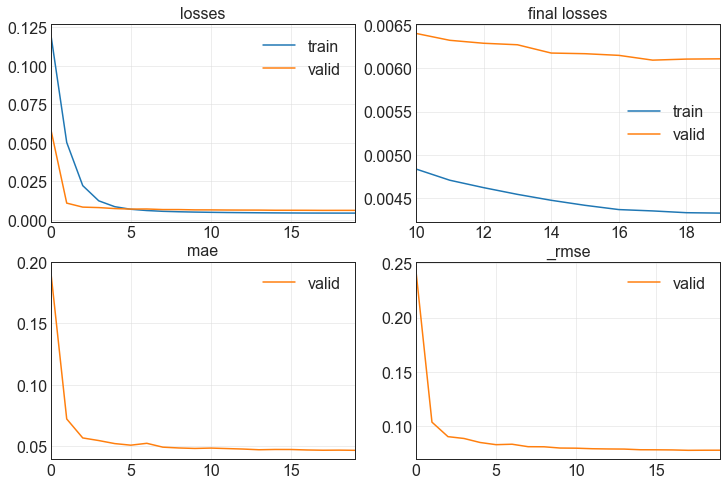

17.713467121124268                                                                                                     
[0.004324255511164665, 0.006111167836934328, 0.04671454802155495, 0.07817395776510239]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
  1%|▍                                             | 1/100 [00:21<33:26, 20.27s/trial, best loss: 0.006111167836934328]

No improvement since epoch 10: early stopping                                                                          
  1%|▍                                             | 1/100 [00:46<33:26, 20.27s/trial, best loss: 0.006111167836934328]

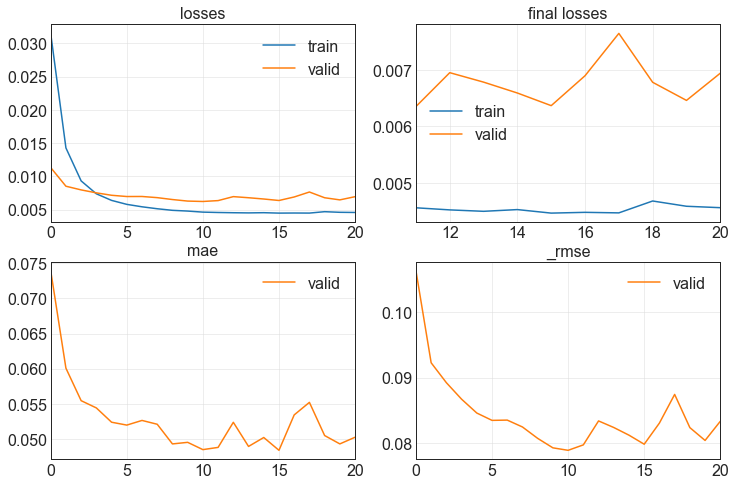

25.420750617980957                                                                                                     
[0.0045622484758496284, 0.006938881240785122, 0.050243932753801346, 0.08329994231462479]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
  2%|▉                                             | 2/100 [00:47<36:09, 22.14s/trial, best loss: 0.006111167836934328]

No improvement since epoch 37: early stopping                                                                          
  2%|▉                                             | 2/100 [03:57<36:09, 22.14s/trial, best loss: 0.006111167836934328]

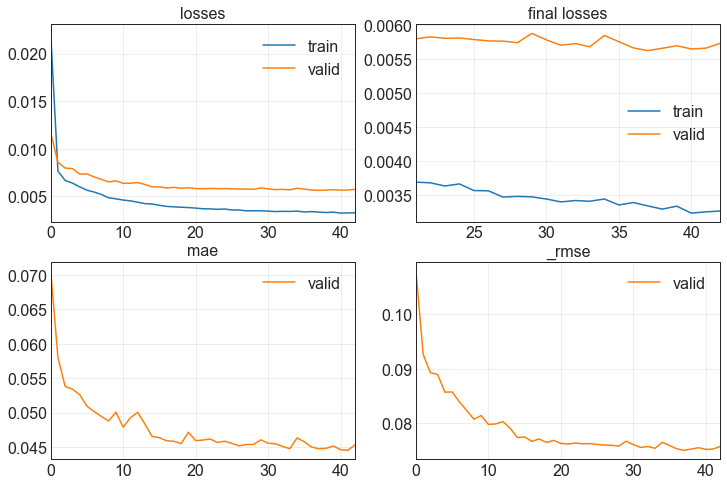

190.02986025810242                                                                                                     
[0.0032664143946021795, 0.005734998732805252, 0.04531402513384819, 0.07572976499795914]                                
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
  3%|█▎                                          | 3/100 [03:59<1:57:45, 72.84s/trial, best loss: 0.005734998732805252]

No improvement since epoch 55: early stopping                                                                          
  3%|█▎                                          | 3/100 [04:57<1:57:45, 72.84s/trial, best loss: 0.005734998732805252]

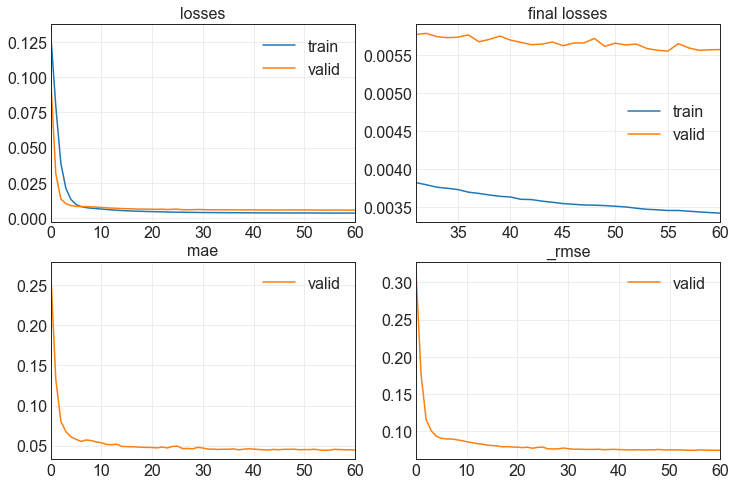

59.18036937713623                                                                                                      
[0.0034170355647802353, 0.0055735064670443535, 0.04465112090110779, 0.0746559277176857]                                
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
  4%|█▋                                         | 4/100 [04:59<1:50:31, 69.07s/trial, best loss: 0.0055735064670443535]

No improvement since epoch 9: early stopping                                                                           
  4%|█▋                                         | 4/100 [05:17<1:50:31, 69.07s/trial, best loss: 0.0055735064670443535]

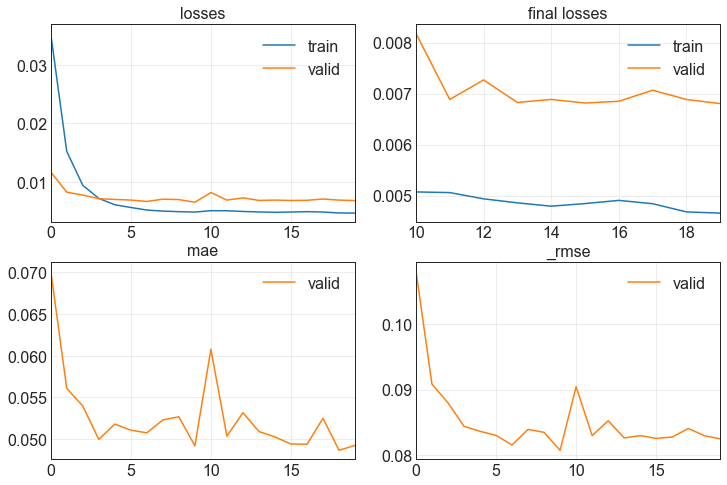

19.0023992061615                                                                                                       
[0.004657799378037453, 0.00680462084710598, 0.04926753789186478, 0.08249012380838394]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.1, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
  5%|██▏                                        | 5/100 [05:19<1:26:06, 54.39s/trial, best loss: 0.0055735064670443535]

No improvement since epoch 42: early stopping                                                                          
  5%|██▏                                        | 5/100 [11:13<1:26:06, 54.39s/trial, best loss: 0.0055735064670443535]

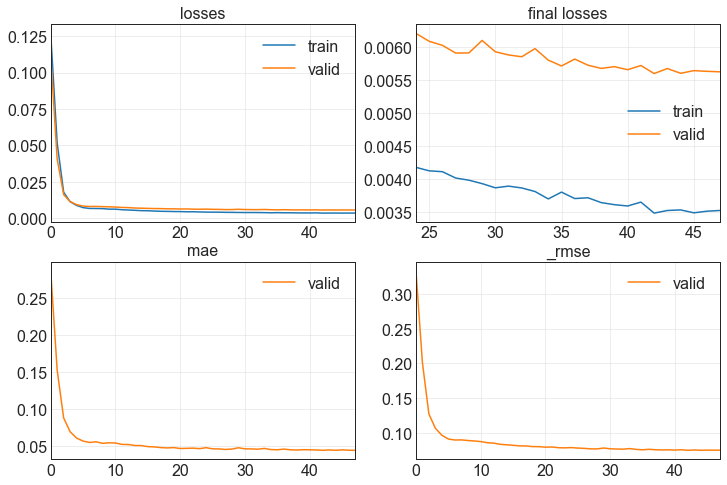

354.4683039188385                                                                                                      
[0.0035207560285925865, 0.00562421977519989, 0.044398315250873566, 0.07499479502439499]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
  6%|██▌                                       | 6/100 [11:15<3:46:45, 144.74s/trial, best loss: 0.0055735064670443535]

No improvement since epoch 44: early stopping                                                                          
  6%|██▌                                       | 6/100 [18:28<3:46:45, 144.74s/trial, best loss: 0.0055735064670443535]

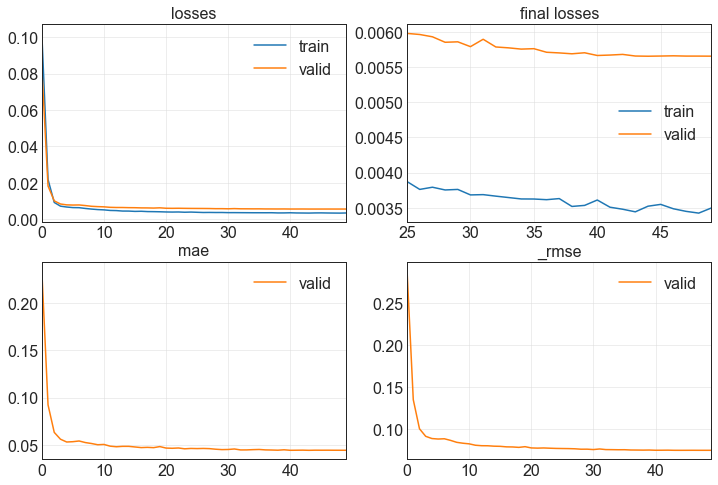

433.9398880004883                                                                                                      
[0.003497876226902008, 0.0056559075601398945, 0.04439515992999077, 0.07520575821399689]                                
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
  7%|██▉                                       | 7/100 [18:30<5:59:21, 231.84s/trial, best loss: 0.0055735064670443535]

No improvement since epoch 88: early stopping                                                                          
  7%|██▉                                       | 7/100 [19:40<5:59:21, 231.84s/trial, best loss: 0.0055735064670443535]

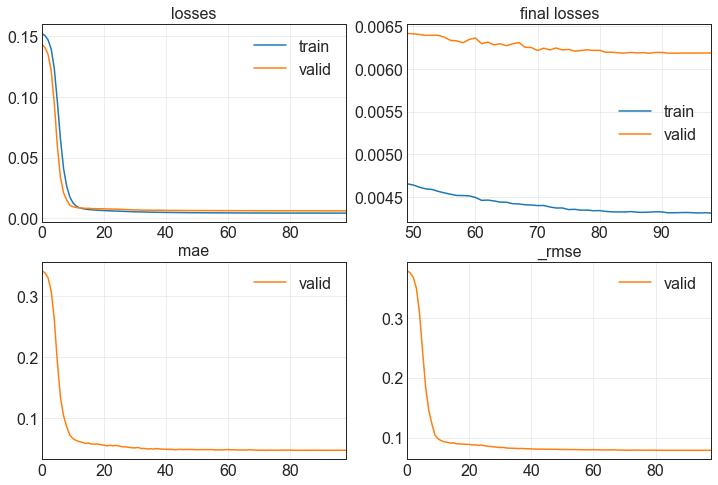

70.42328953742981                                                                                                      
[0.004308165051043034, 0.0061876364052295685, 0.04712464660406113, 0.07866153120994568]                                
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.1, 'epochs': 50, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
  8%|███▎                                      | 8/100 [19:41<4:41:45, 183.75s/trial, best loss: 0.0055735064670443535]

No improvement since epoch 36: early stopping                                                                          
  8%|███▎                                      | 8/100 [20:29<4:41:45, 183.75s/trial, best loss: 0.0055735064670443535]

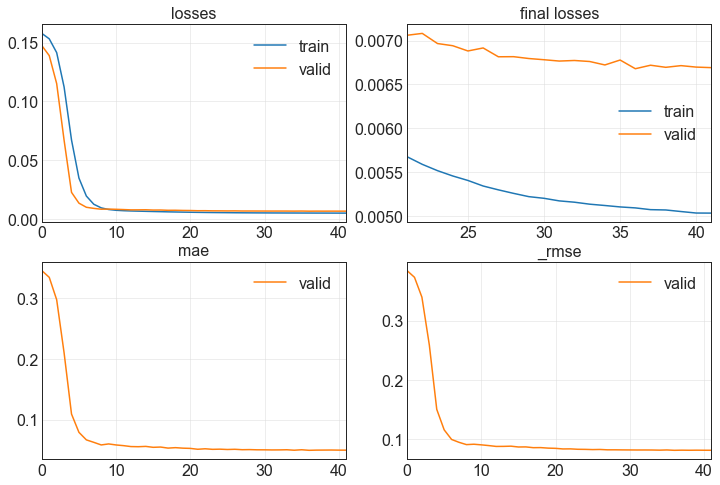

48.5928258895874                                                                                                       
[0.005032878369092941, 0.006690764334052801, 0.04948628321290016, 0.08179709315299988]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
  9%|███▊                                      | 9/100 [20:31<3:37:41, 143.53s/trial, best loss: 0.0055735064670443535]

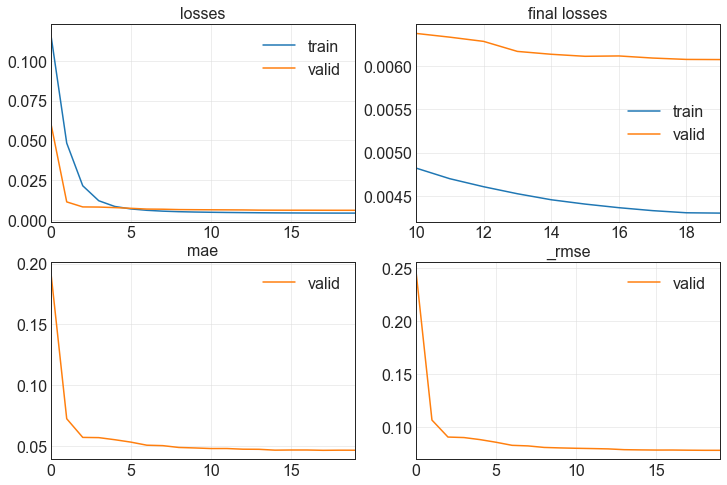

14.774717807769775                                                                                                     
[0.004298756830394268, 0.006078440696001053, 0.04680686444044113, 0.07796436548233032]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 10%|████                                     | 10/100 [20:47<2:37:50, 105.23s/trial, best loss: 0.0055735064670443535]

No improvement since epoch 12: early stopping                                                                          
 10%|████                                     | 10/100 [21:16<2:37:50, 105.23s/trial, best loss: 0.0055735064670443535]

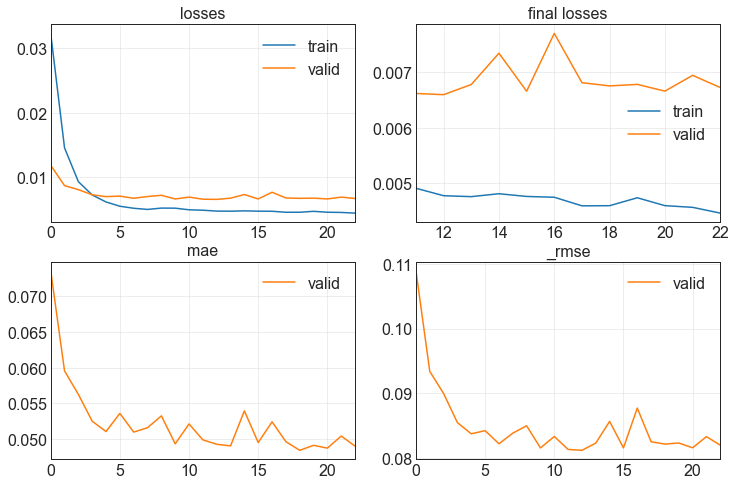

29.252455711364746                                                                                                     
[0.004466150421649218, 0.006724732927978039, 0.049012430012226105, 0.08200446516275406]                                
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 11%|████▌                                     | 11/100 [21:17<2:02:47, 82.79s/trial, best loss: 0.0055735064670443535]

No improvement since epoch 10: early stopping                                                                          
 11%|████▌                                     | 11/100 [21:32<2:02:47, 82.79s/trial, best loss: 0.0055735064670443535]

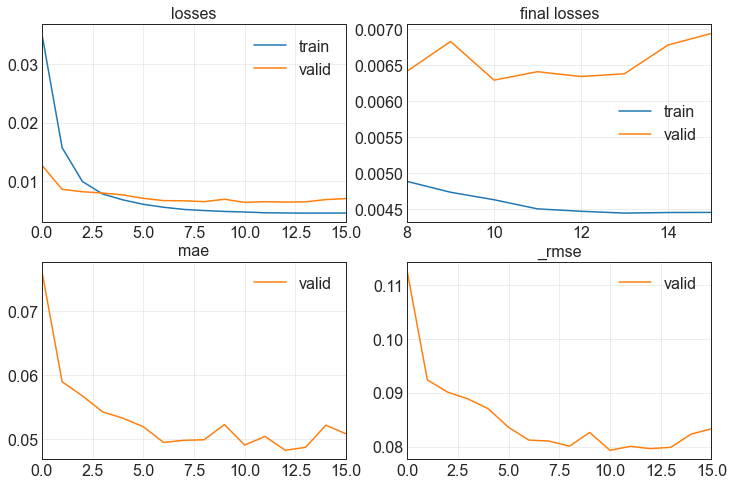

15.78465223312378                                                                                                      
[0.0044578430242836475, 0.006937224417924881, 0.050775740295648575, 0.08329001069068909]                               
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.1, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 12%|█████                                     | 12/100 [21:34<1:32:25, 63.01s/trial, best loss: 0.0055735064670443535]

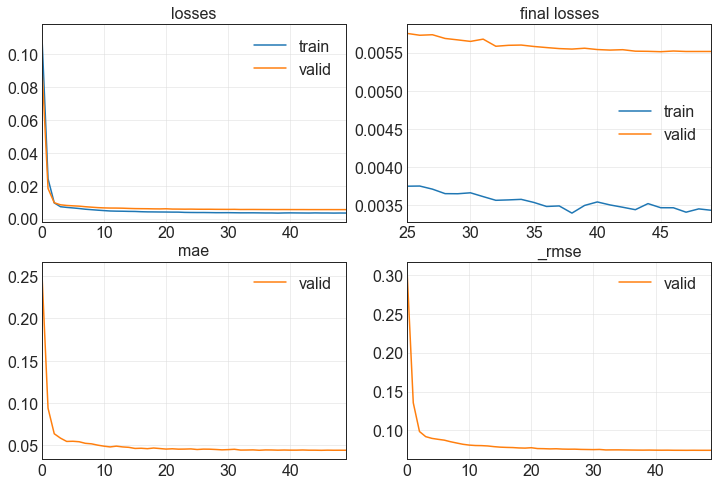

366.26043224334717                                                                                                     
[0.003435596125200391, 0.005516116041690111, 0.044127028435468674, 0.0742705687880516]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.5, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 13%|█████▍                                    | 13/100 [27:41<3:43:45, 154.32s/trial, best loss: 0.005516116041690111]

No improvement since epoch 44: early stopping                                                                          
 13%|█████▍                                    | 13/100 [28:28<3:43:45, 154.32s/trial, best loss: 0.005516116041690111]

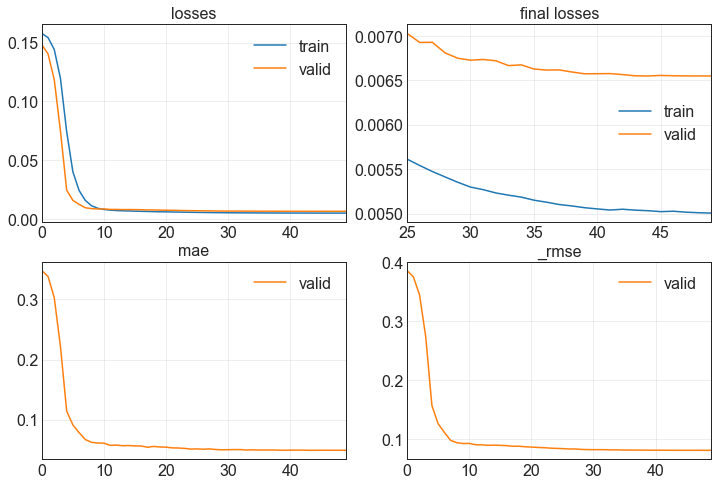

47.40582990646362                                                                                                      
[0.005005027633160353, 0.006547815632075071, 0.04904898256063461, 0.0809185728430748]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 14%|█████▉                                    | 14/100 [28:30<2:55:42, 122.59s/trial, best loss: 0.005516116041690111]

No improvement since epoch 27: early stopping                                                                          
 14%|█████▉                                    | 14/100 [29:14<2:55:42, 122.59s/trial, best loss: 0.005516116041690111]

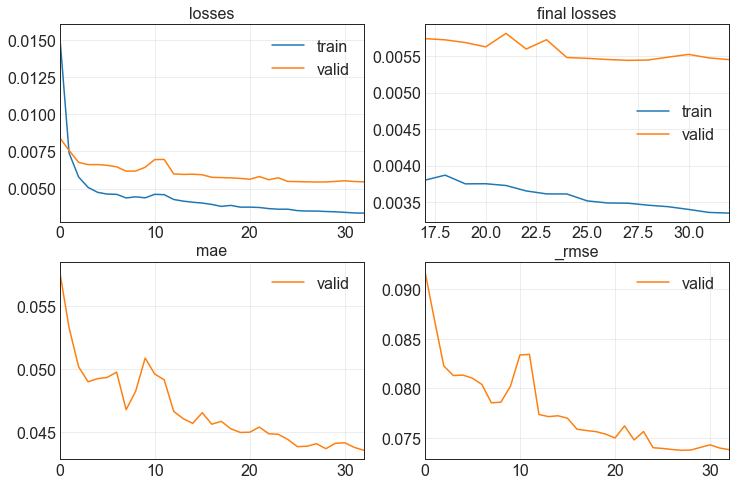

44.101608991622925                                                                                                     
[0.0033503470476716757, 0.0054521081037819386, 0.0435294546186924, 0.07383839040994644]                                
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 15%|██████▎                                   | 15/100 [29:15<2:20:46, 99.37s/trial, best loss: 0.0054521081037819386]

No improvement since epoch 10: early stopping                                                                          
 15%|██████▎                                   | 15/100 [29:51<2:20:46, 99.37s/trial, best loss: 0.0054521081037819386]

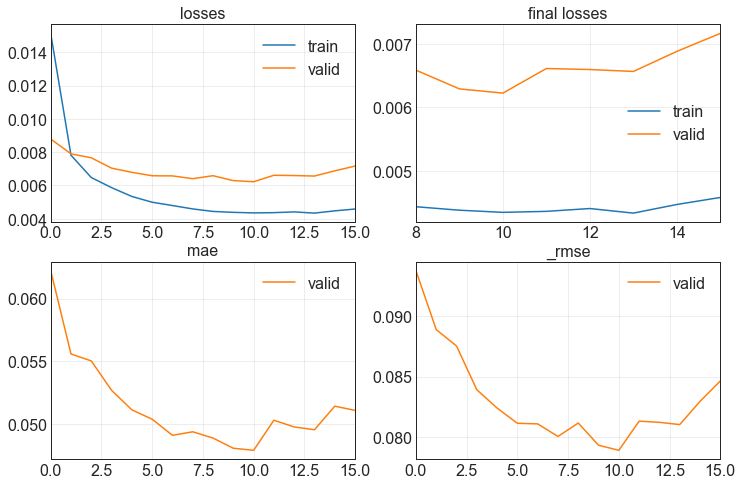

36.53830122947693                                                                                                      
[0.004586282651871443, 0.007163446396589279, 0.051069118082523346, 0.08463714271783829]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 16%|██████▋                                   | 16/100 [29:53<1:53:11, 80.85s/trial, best loss: 0.0054521081037819386]

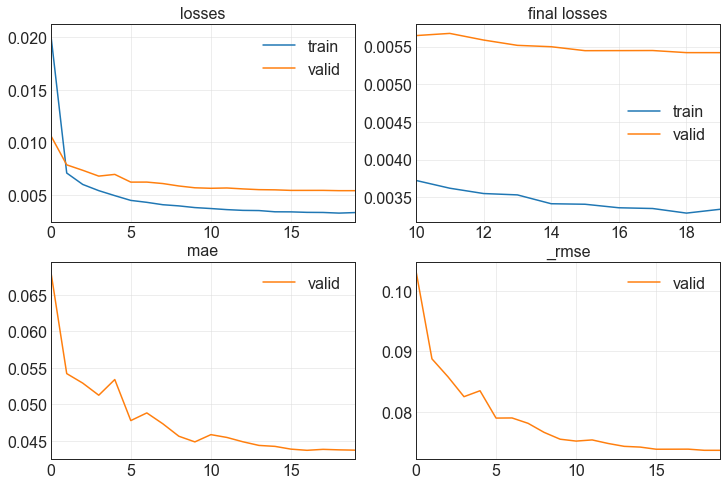

52.30595397949219                                                                                                      
[0.0033399465028196573, 0.005421166308224201, 0.0437212735414505, 0.07362856715917587]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 17%|███████▎                                   | 17/100 [30:46<1:40:26, 72.61s/trial, best loss: 0.005421166308224201]

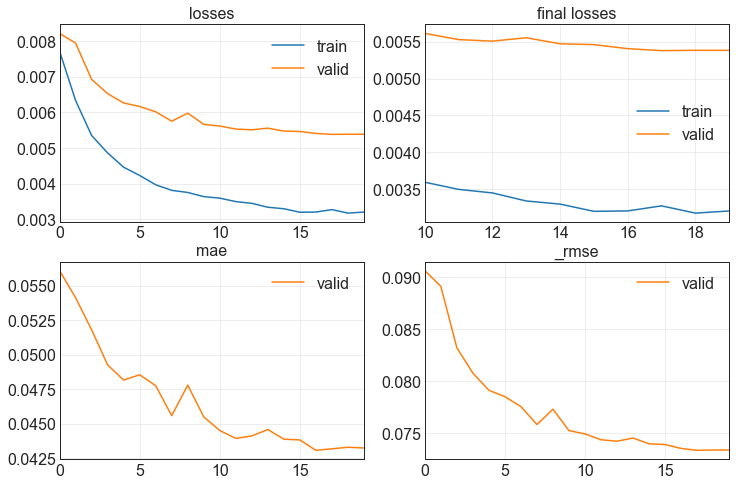

174.92163181304932                                                                                                     
[0.003200920531526208, 0.005382516887038946, 0.04324103519320488, 0.07336564362049103]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.1, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 18%|███████▌                                  | 18/100 [33:42<2:21:38, 103.64s/trial, best loss: 0.005382516887038946]

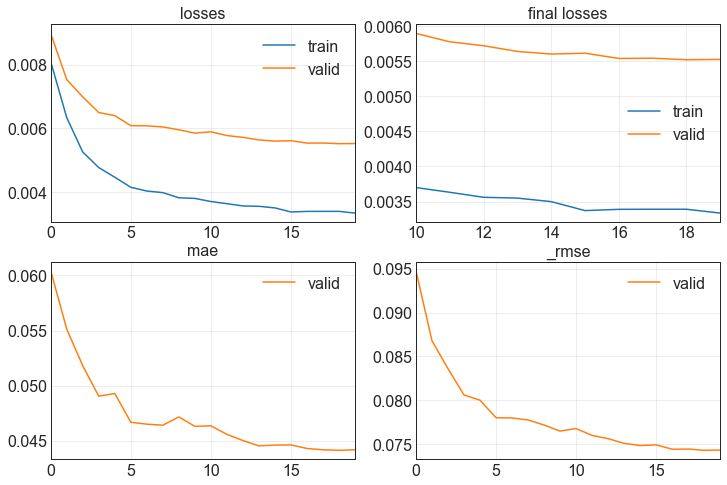

143.95879912376404                                                                                                     
[0.003337135072797537, 0.0055230422876775265, 0.044170767068862915, 0.07431717962026596]                               
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 19%|███████▉                                  | 19/100 [36:07<2:36:41, 116.07s/trial, best loss: 0.005382516887038946]

No improvement since epoch 12: early stopping                                                                          
 19%|███████▉                                  | 19/100 [36:28<2:36:41, 116.07s/trial, best loss: 0.005382516887038946]

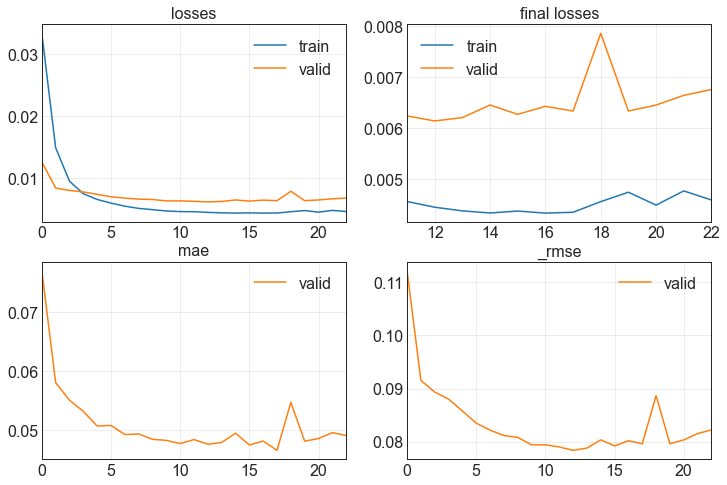

21.298345804214478                                                                                                     
[0.004591987002640963, 0.00676129711791873, 0.049145013093948364, 0.08222711086273193]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 20%|████████▌                                  | 20/100 [36:30<1:57:17, 87.97s/trial, best loss: 0.005382516887038946]

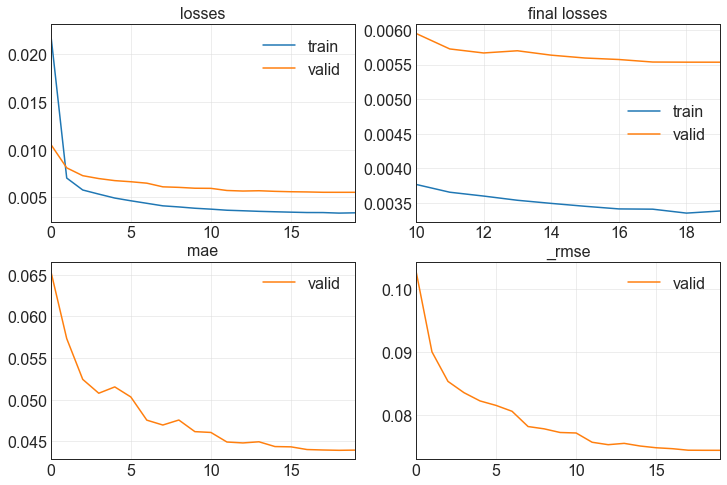

52.24792790412903                                                                                                      
[0.003385458141565323, 0.005535729229450226, 0.04394964128732681, 0.07440248131752014]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 21%|█████████                                  | 21/100 [37:23<1:42:08, 77.58s/trial, best loss: 0.005382516887038946]

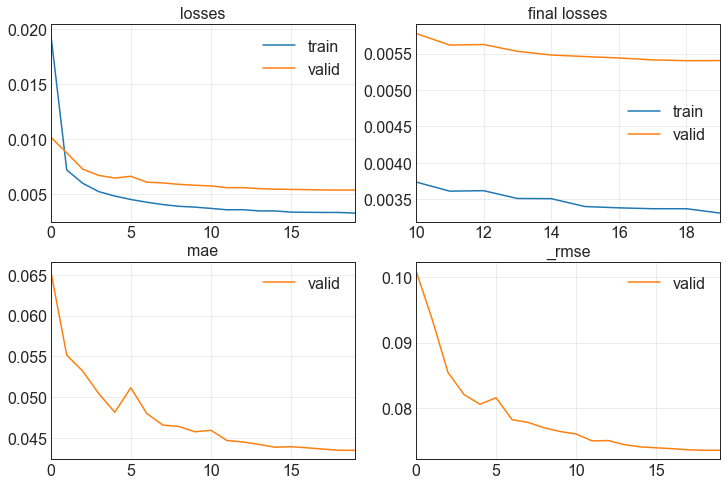

52.17874002456665                                                                                                      
[0.003310343250632286, 0.005403113551437855, 0.043453846126794815, 0.07350587099790573]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 22%|█████████▍                                 | 22/100 [38:16<1:31:22, 70.29s/trial, best loss: 0.005382516887038946]

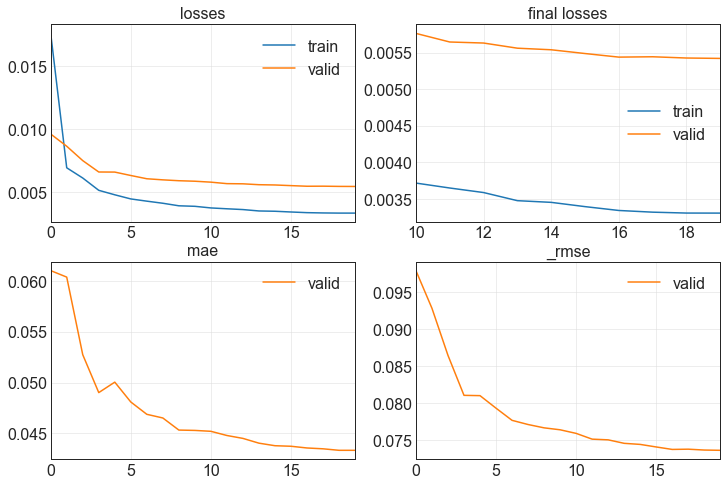

86.4030249118805                                                                                                       
[0.003303918754681945, 0.00542105408385396, 0.04332689195871353, 0.07362781465053558]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 23%|█████████▉                                 | 23/100 [39:44<1:36:49, 75.45s/trial, best loss: 0.005382516887038946]

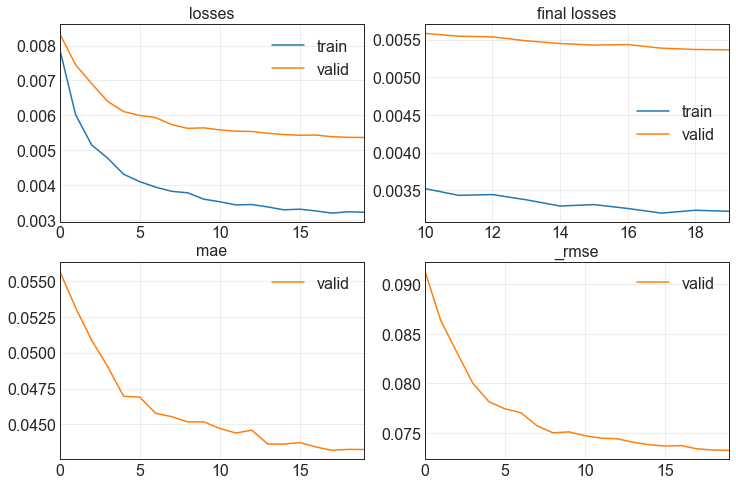

104.3450767993927                                                                                                      
[0.0032202599104493856, 0.005364287178963423, 0.04325801134109497, 0.07324129343032837]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 24%|██████████▎                                | 24/100 [41:29<1:46:58, 84.45s/trial, best loss: 0.005364287178963423]

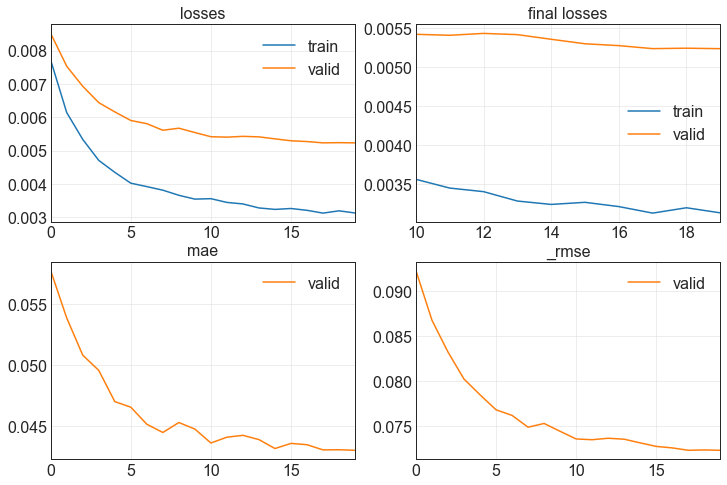

103.73329472541809                                                                                                     
[0.0031283574644476175, 0.005232637282460928, 0.043005988001823425, 0.07233697175979614]                               
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 25%|██████████▊                                | 25/100 [43:14<1:53:11, 90.56s/trial, best loss: 0.005232637282460928]

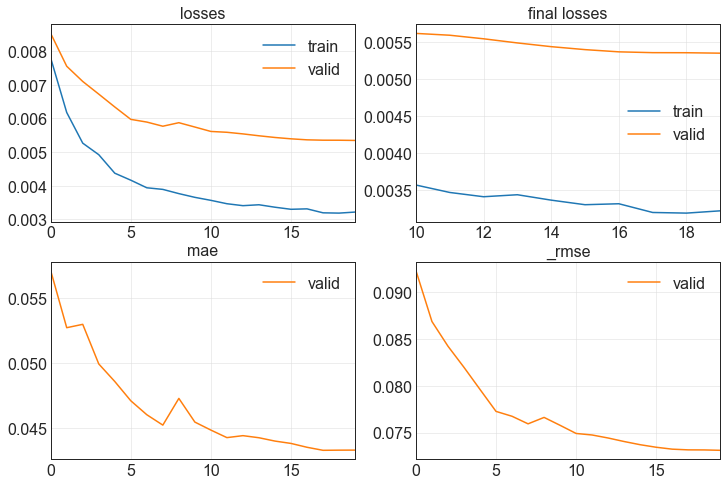

103.6025779247284                                                                                                      
[0.0032186920288950205, 0.005346065387129784, 0.04328428953886032, 0.07311680167913437]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 26%|███████████▏                               | 26/100 [44:59<1:56:55, 94.80s/trial, best loss: 0.005232637282460928]

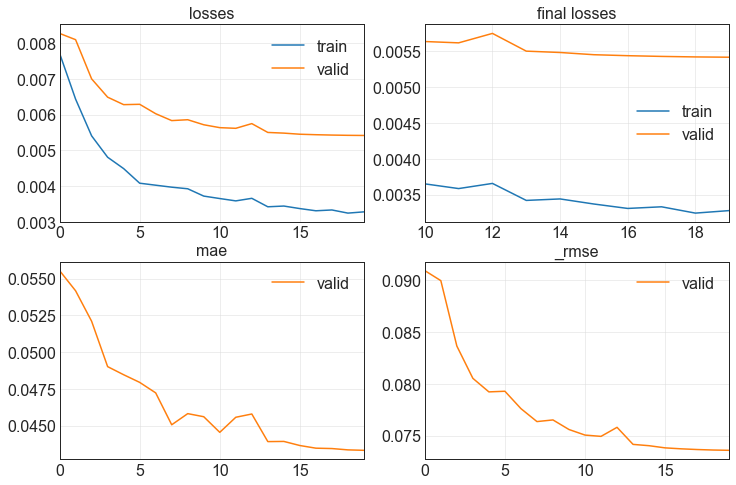

103.57848501205444                                                                                                     
[0.003276916453614831, 0.005415181163698435, 0.04331463575363159, 0.07358791679143906]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 27%|███████████▌                               | 27/100 [46:43<1:58:56, 97.76s/trial, best loss: 0.005232637282460928]

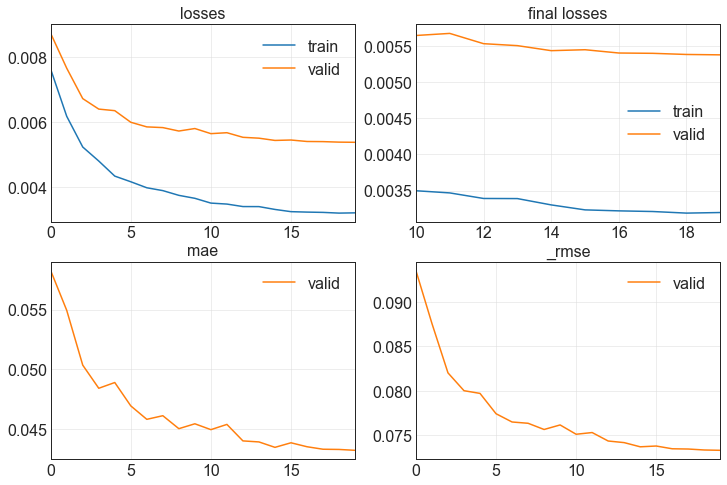

103.59024310112                                                                                                        
[0.003196724923327565, 0.005376612767577171, 0.04323294758796692, 0.07332539558410645]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.5, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 28%|████████████                               | 28/100 [48:28<1:59:48, 99.84s/trial, best loss: 0.005232637282460928]

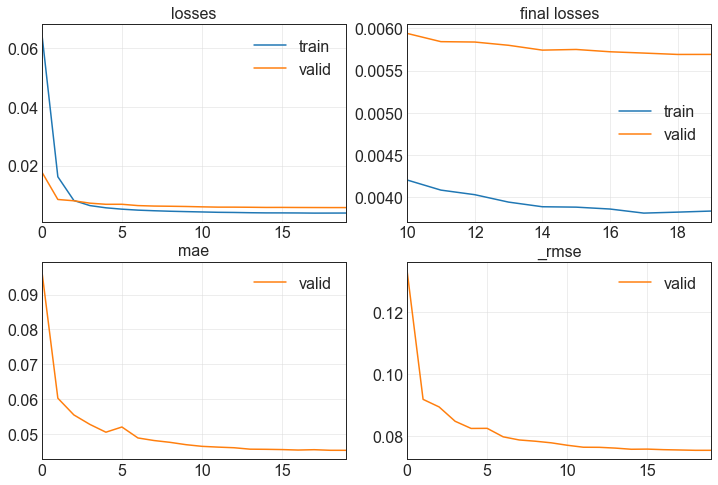

27.363457441329956                                                                                                     
[0.0038351533003151417, 0.005692386534065008, 0.04523248225450516, 0.07544790953397751]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 29%|████████████▍                              | 29/100 [48:56<1:32:48, 78.43s/trial, best loss: 0.005232637282460928]

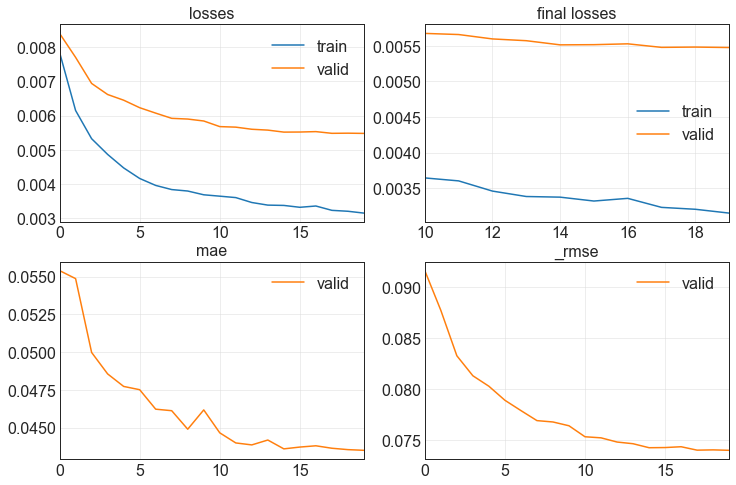

103.55649757385254                                                                                                     
[0.0031481245532631874, 0.005477795843034983, 0.04349392279982567, 0.0740121454000473]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.5, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 30%|████████████▉                              | 30/100 [50:41<1:40:40, 86.30s/trial, best loss: 0.005232637282460928]

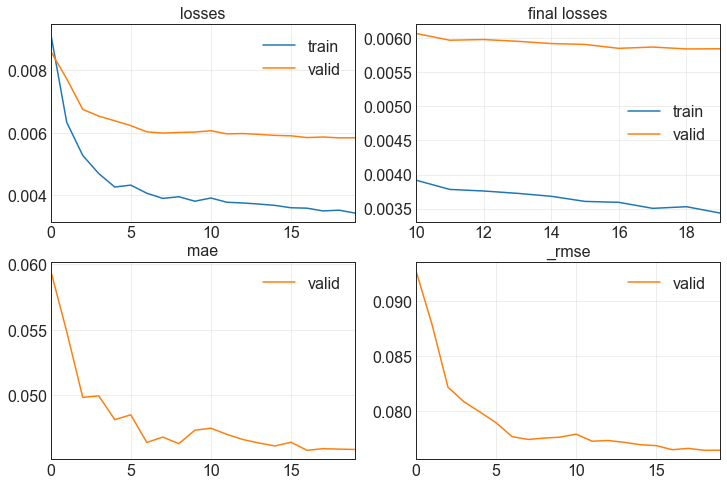

106.62415266036987                                                                                                     
[0.003435499034821987, 0.005841879639774561, 0.04587002471089363, 0.07643218338489532]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 31%|█████████████▎                             | 31/100 [52:29<1:46:37, 92.72s/trial, best loss: 0.005232637282460928]

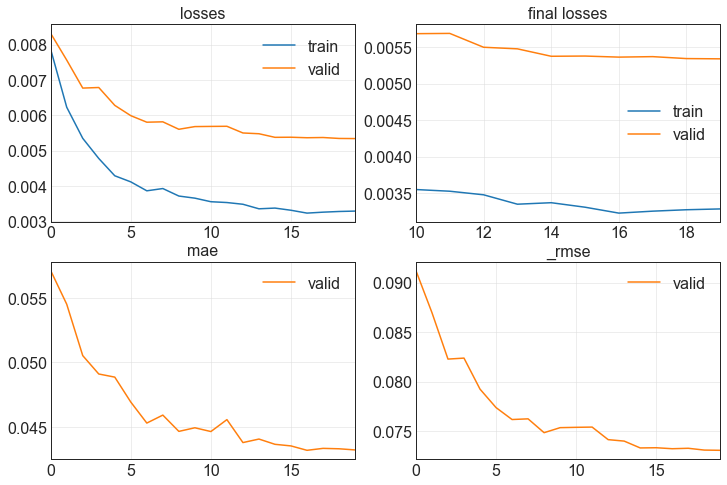

103.5249330997467                                                                                                      
[0.0032833183649927378, 0.005338077899068594, 0.04322303086519241, 0.07306215167045593]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.1, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 32%|█████████████▊                             | 32/100 [54:14<1:49:08, 96.30s/trial, best loss: 0.005232637282460928]

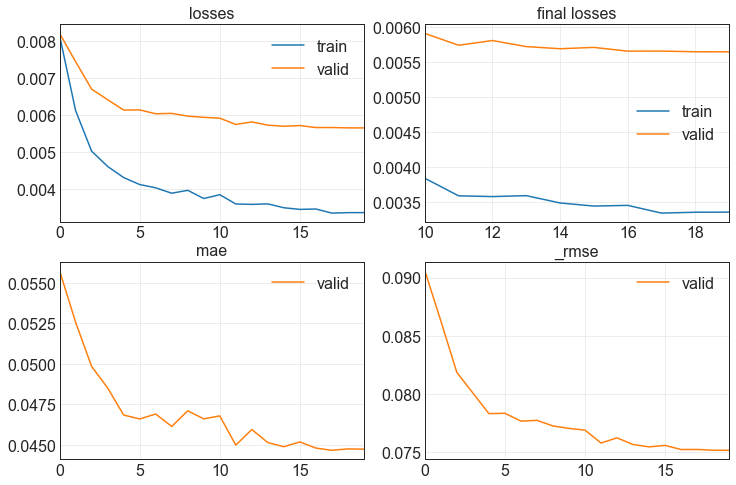

106.7732081413269                                                                                                      
[0.0033592877443879843, 0.005650936160236597, 0.04472817853093147, 0.07517270743846893]                                
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 33%|██████████████▏                            | 33/100 [56:01<1:51:24, 99.77s/trial, best loss: 0.005232637282460928]

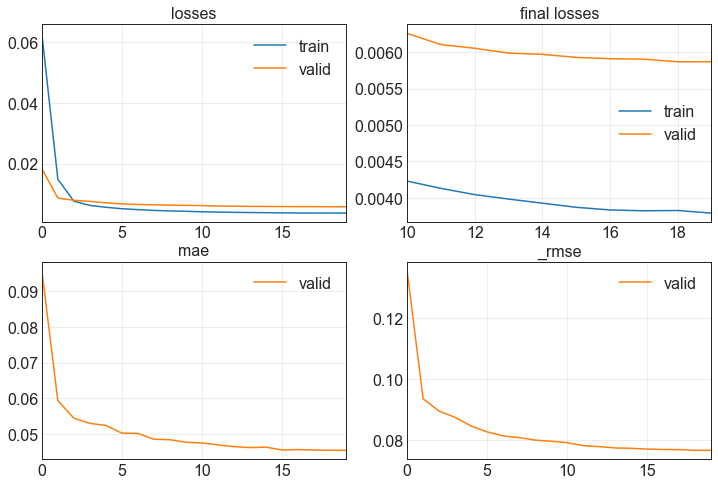

26.530490398406982                                                                                                     
[0.003789542941376567, 0.005870904307812452, 0.045477140694856644, 0.07662183046340942]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.5, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 34%|██████████████▌                            | 34/100 [56:29<1:25:56, 78.13s/trial, best loss: 0.005232637282460928]

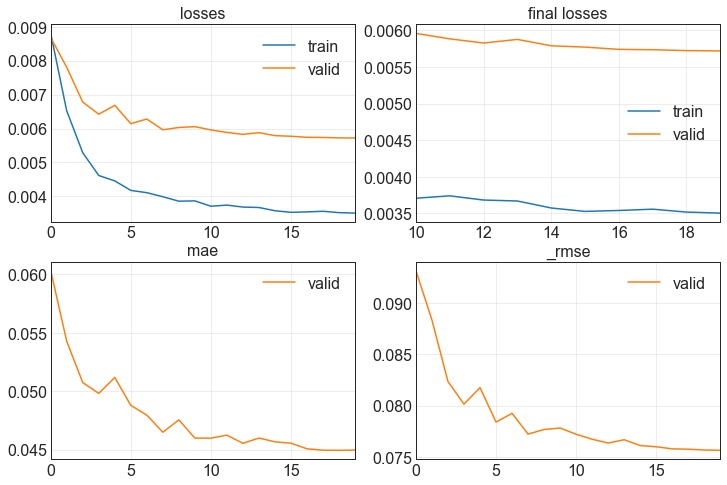

106.86073184013367                                                                                                     
[0.0035052415914833546, 0.005719303153455257, 0.04495948180556297, 0.07562607526779175]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 35%|███████████████                            | 35/100 [58:17<1:34:20, 87.08s/trial, best loss: 0.005232637282460928]

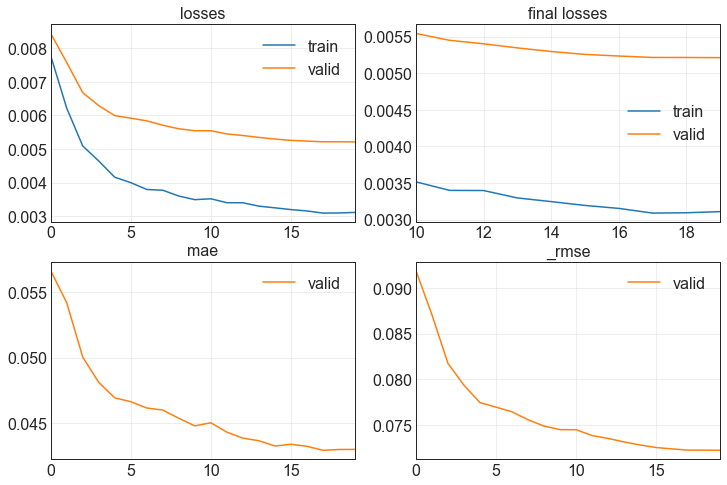

103.40787601470947                                                                                                     
[0.0031095328740775585, 0.005212754476815462, 0.04296271875500679, 0.07219941169023514]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 36%|██████████████▊                          | 36/100 [1:00:01<1:38:27, 92.31s/trial, best loss: 0.005212754476815462]

No improvement since epoch 86: early stopping                                                                          
 36%|██████████████▊                          | 36/100 [1:08:38<1:38:27, 92.31s/trial, best loss: 0.005212754476815462]

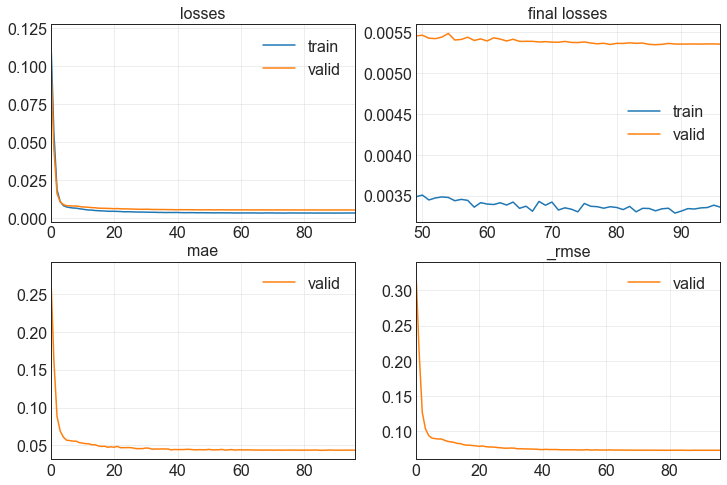

517.2220277786255                                                                                                      
[0.003358997404575348, 0.005355051252990961, 0.043704476207494736, 0.07317821681499481]                                
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 37%|██████████████▊                         | 37/100 [1:08:40<3:51:07, 220.11s/trial, best loss: 0.005212754476815462]

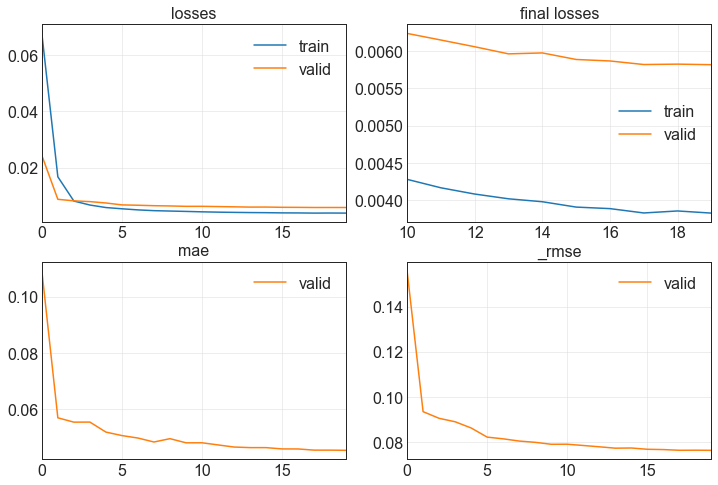

26.60253357887268                                                                                                      
[0.0038272254168987274, 0.005816103424876928, 0.045270875096321106, 0.07626339048147202]                               
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.1, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 38%|███████████████▏                        | 38/100 [1:09:08<2:47:48, 162.40s/trial, best loss: 0.005212754476815462]

No improvement since epoch 1: early stopping                                                                           
 38%|███████████████▏                        | 38/100 [1:10:11<2:47:48, 162.40s/trial, best loss: 0.005212754476815462]

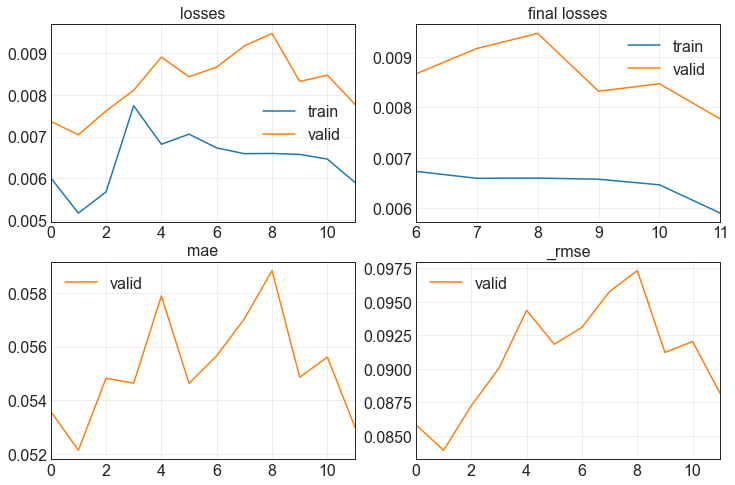

64.16575384140015                                                                                                      
[0.005898946430534124, 0.007770823780447245, 0.05298985540866852, 0.08815228193998337]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 39%|███████████████▌                        | 39/100 [1:10:13<2:15:28, 133.26s/trial, best loss: 0.005212754476815462]

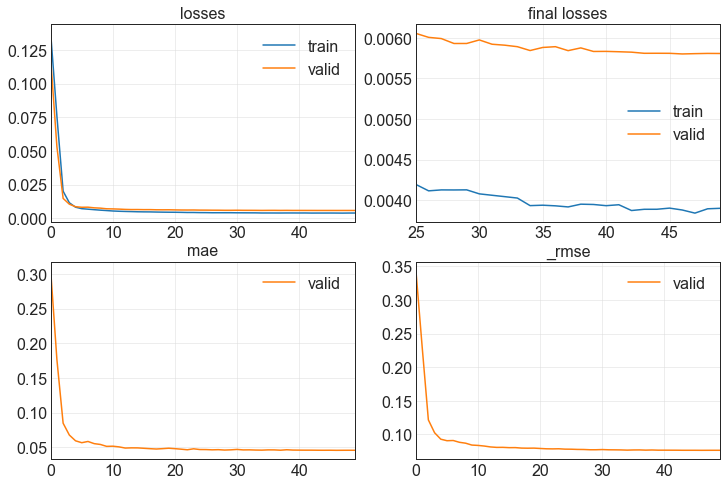

222.79463839530945                                                                                                     
[0.0039022229611873627, 0.005806939676403999, 0.045556604862213135, 0.07620327919721603]                               
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 40%|████████████████                        | 40/100 [1:13:57<2:40:27, 160.45s/trial, best loss: 0.005212754476815462]

No improvement since epoch 61: early stopping                                                                          
 40%|████████████████                        | 40/100 [1:20:09<2:40:27, 160.45s/trial, best loss: 0.005212754476815462]

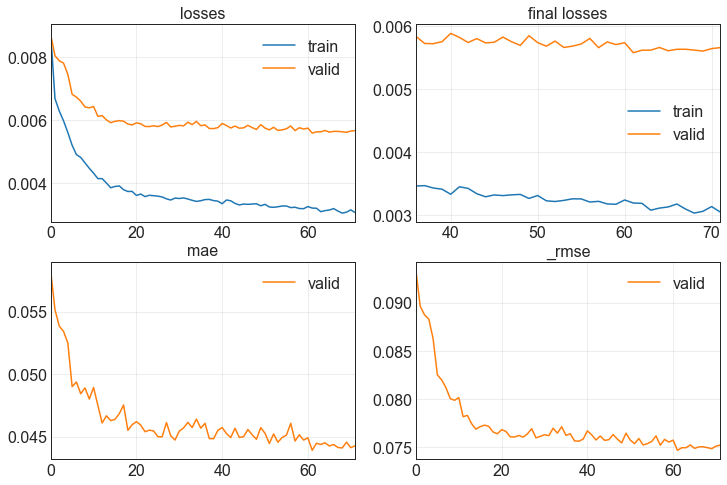

372.2944097518921                                                                                                      
[0.003053447464480996, 0.005658190231770277, 0.04425693303346634, 0.07522094249725342]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.1, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 41%|████████████████▍                       | 41/100 [1:20:10<3:40:36, 224.34s/trial, best loss: 0.005212754476815462]

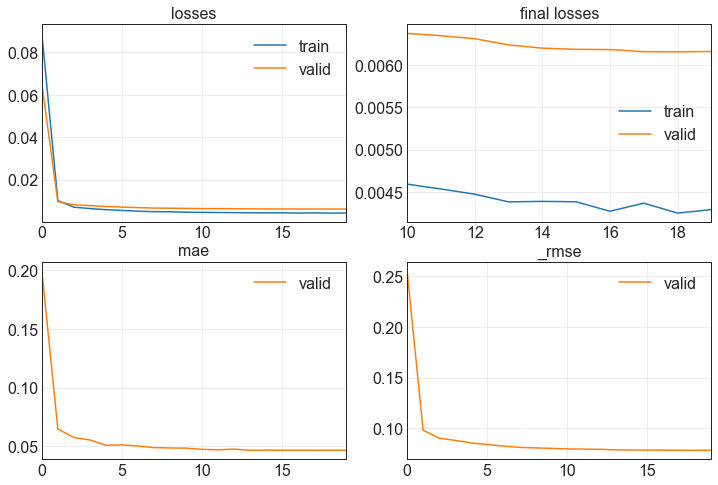

142.96581530570984                                                                                                     
[0.004288117866963148, 0.006163273472338915, 0.04681406542658806, 0.07850652188062668]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 42%|████████████████▊                       | 42/100 [1:22:34<3:13:35, 200.27s/trial, best loss: 0.005212754476815462]

No improvement since epoch 3: early stopping                                                                           
 42%|████████████████▊                       | 42/100 [1:23:55<3:13:35, 200.27s/trial, best loss: 0.005212754476815462]

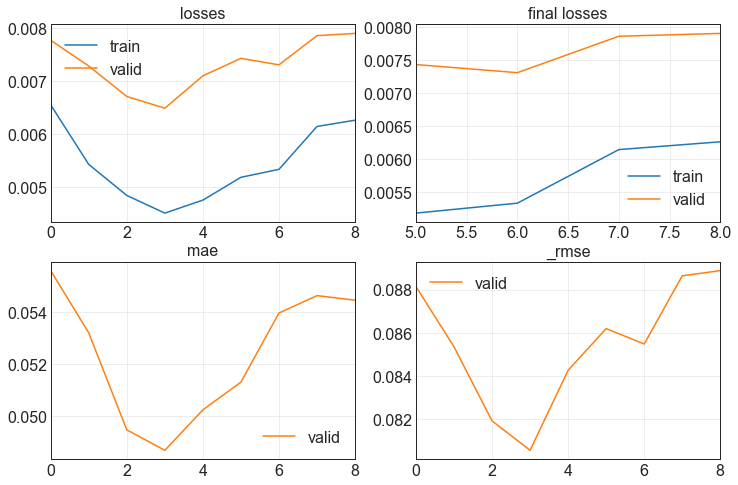

80.86538195610046                                                                                                      
[0.006264018826186657, 0.007899800315499306, 0.054473474621772766, 0.08888081461191177]                                
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 43%|█████████████████▏                      | 43/100 [1:23:56<2:36:32, 164.78s/trial, best loss: 0.005212754476815462]

No improvement since epoch 80: early stopping                                                                          
 43%|█████████████████▏                      | 43/100 [1:25:56<2:36:32, 164.78s/trial, best loss: 0.005212754476815462]

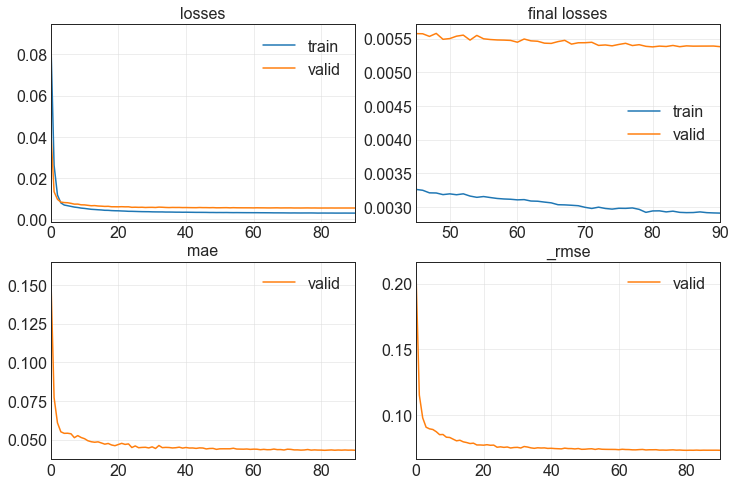

119.85859274864197                                                                                                     
[0.002906954614445567, 0.005379121284931898, 0.04318123683333397, 0.07334248721599579]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 44%|█████████████████▌                      | 44/100 [1:25:57<2:21:31, 151.63s/trial, best loss: 0.005212754476815462]

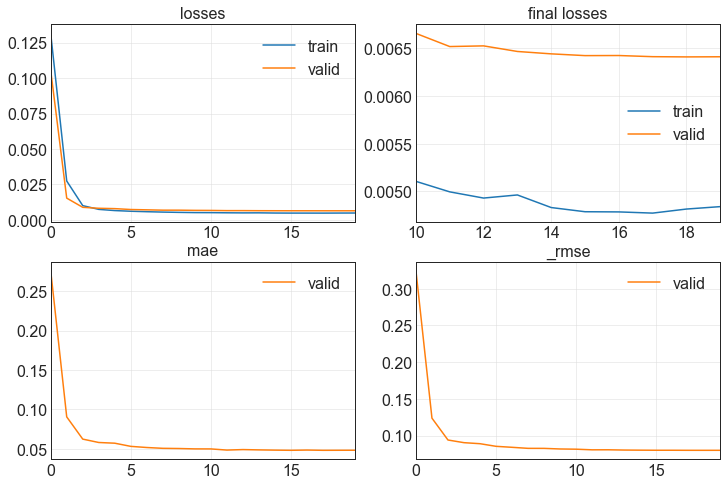

71.46181535720825                                                                                                      
[0.004840645473450422, 0.006412444170564413, 0.048275820910930634, 0.08007773011922836]                                
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 45%|██████████████████                      | 45/100 [1:27:10<1:57:15, 127.92s/trial, best loss: 0.005212754476815462]

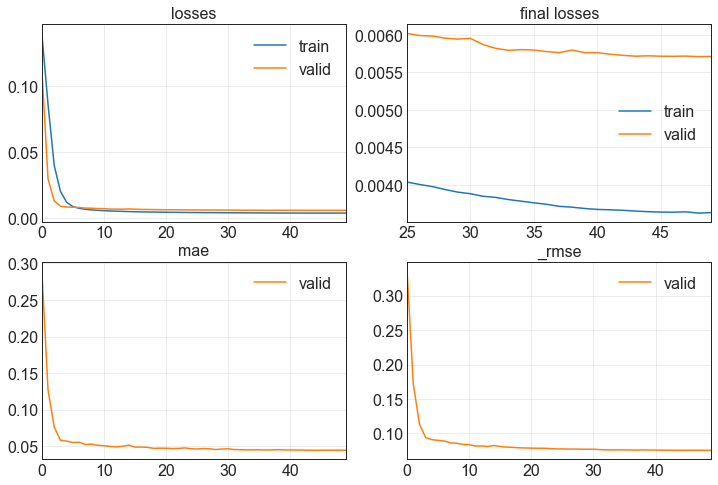

34.5940637588501                                                                                                       
[0.0036313196178525686, 0.005710417404770851, 0.04449506849050522, 0.07556731253862381]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 46%|██████████████████▍                     | 46/100 [1:27:45<1:30:13, 100.25s/trial, best loss: 0.005212754476815462]

No improvement since epoch 2: early stopping                                                                           
 46%|██████████████████▍                     | 46/100 [1:28:57<1:30:13, 100.25s/trial, best loss: 0.005212754476815462]

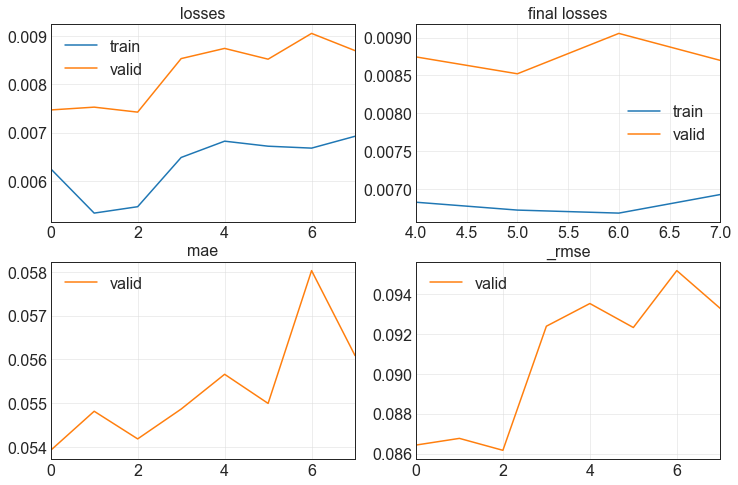

71.79827952384949                                                                                                      
[0.006924543995410204, 0.008698660880327225, 0.05608418583869934, 0.09326662868261337]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.1, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 47%|███████████████████▎                     | 47/100 [1:28:58<1:21:18, 92.05s/trial, best loss: 0.005212754476815462]

No improvement since epoch 35: early stopping                                                                          
 47%|███████████████████▎                     | 47/100 [1:33:03<1:21:18, 92.05s/trial, best loss: 0.005212754476815462]

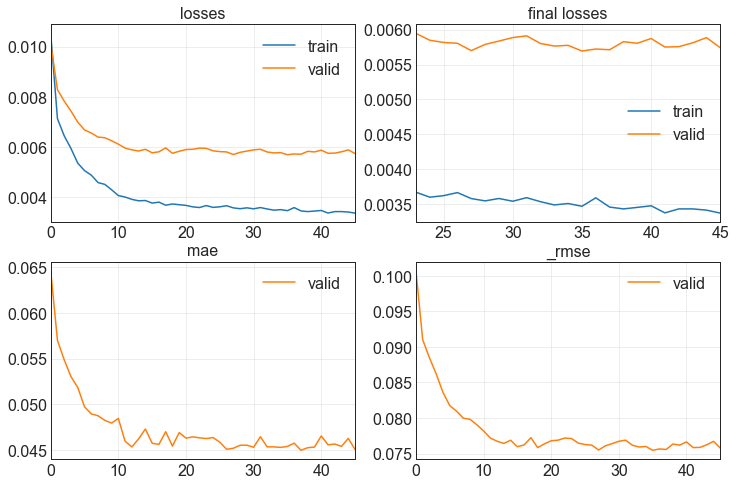

245.2252814769745                                                                                                      
[0.003369488986209035, 0.005741337779909372, 0.045066092163324356, 0.07577161490917206]                                
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 48%|███████████████████▏                    | 48/100 [1:33:05<1:59:53, 138.33s/trial, best loss: 0.005212754476815462]

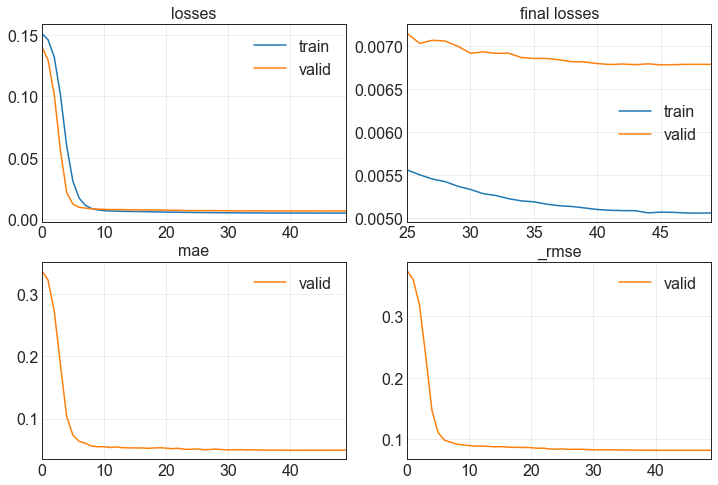

45.332868814468384                                                                                                     
[0.00505923992022872, 0.006783554796129465, 0.04928279668092728, 0.0823623389005661]                                   
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.5, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 49%|███████████████████▌                    | 49/100 [1:33:51<1:34:09, 110.77s/trial, best loss: 0.005212754476815462]

No improvement since epoch 5: early stopping                                                                           
 49%|███████████████████▌                    | 49/100 [1:34:06<1:34:09, 110.77s/trial, best loss: 0.005212754476815462]

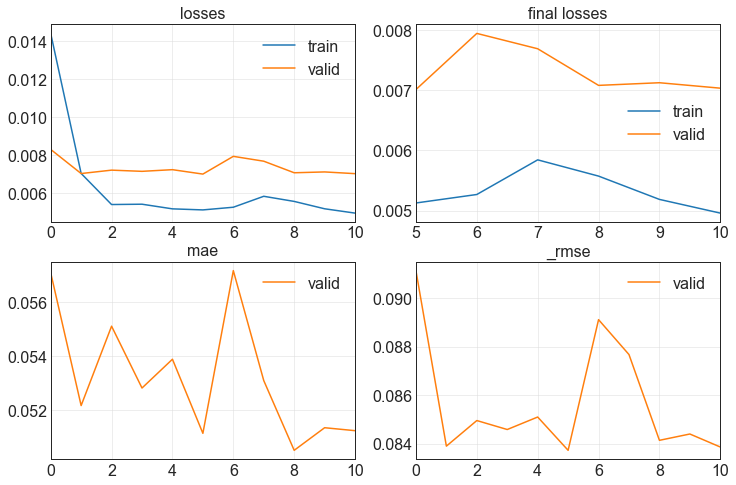

15.293335676193237                                                                                                     
[0.004960149060934782, 0.007032329216599464, 0.05124139040708542, 0.08385898172855377]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 50%|████████████████████▌                    | 50/100 [1:34:08<1:08:42, 82.46s/trial, best loss: 0.005212754476815462]

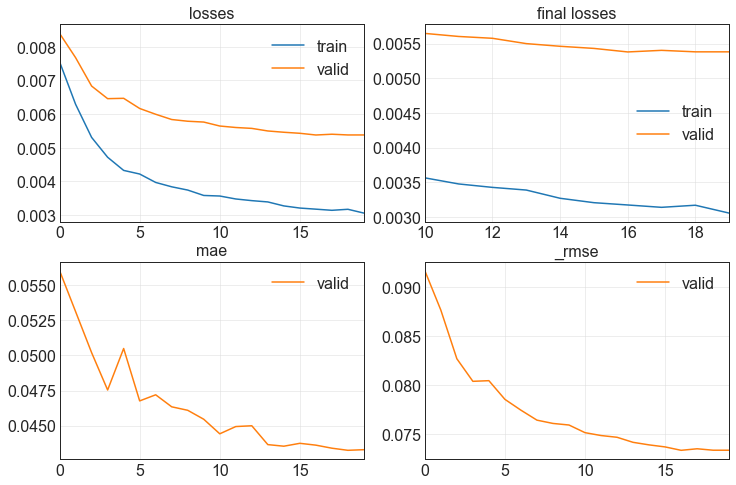

172.54064917564392                                                                                                     
[0.003055514534935355, 0.005379805341362953, 0.043295711278915405, 0.07334714382886887]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 51%|████████████████████▍                   | 51/100 [1:37:01<1:29:40, 109.82s/trial, best loss: 0.005212754476815462]

No improvement since epoch 32: early stopping                                                                          
 51%|████████████████████▍                   | 51/100 [1:39:12<1:29:40, 109.82s/trial, best loss: 0.005212754476815462]

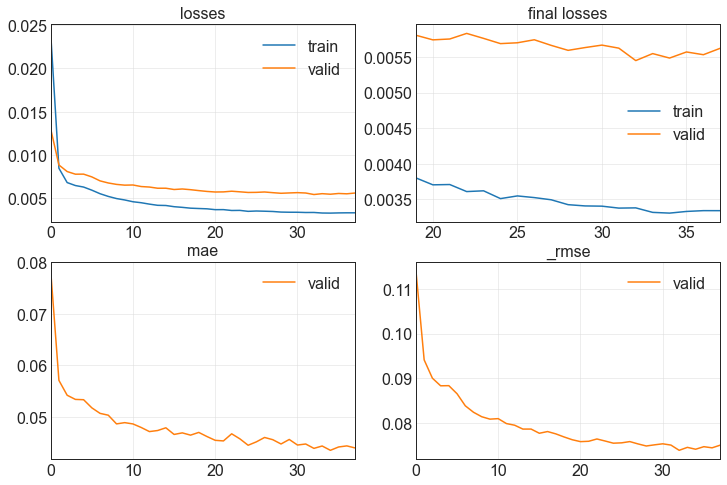

130.96998357772827                                                                                                     
[0.0033407460432499647, 0.00562408659607172, 0.04400249570608139, 0.07499390840530396]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 52%|████████████████████▊                   | 52/100 [1:39:13<1:33:11, 116.49s/trial, best loss: 0.005212754476815462]

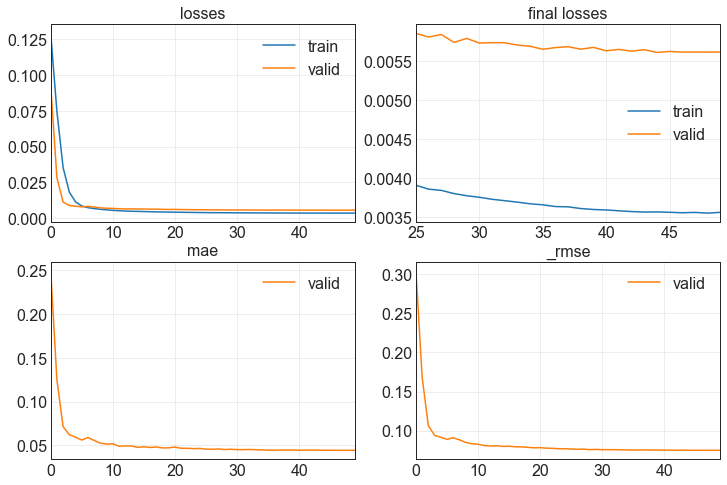

35.47519874572754                                                                                                      
[0.0035563602577894926, 0.005614216439425945, 0.044533200562000275, 0.07492807507514954]                               
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.1, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 53%|█████████████████████▋                   | 53/100 [1:39:50<1:12:28, 92.51s/trial, best loss: 0.005212754476815462]

No improvement since epoch 1: early stopping                                                                           
 53%|█████████████████████▋                   | 53/100 [1:40:54<1:12:28, 92.51s/trial, best loss: 0.005212754476815462]

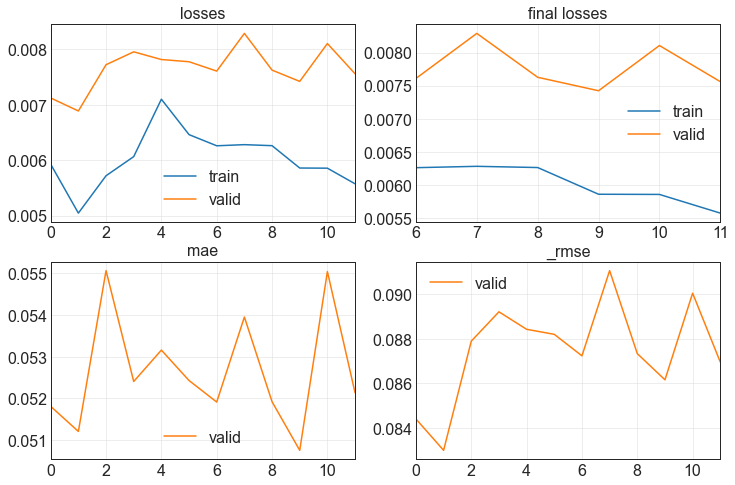

64.17090249061584                                                                                                      
[0.0055739679373800755, 0.007561245001852512, 0.05213635042309761, 0.08695542812347412]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 54%|██████████████████████▏                  | 54/100 [1:40:55<1:04:39, 84.34s/trial, best loss: 0.005212754476815462]

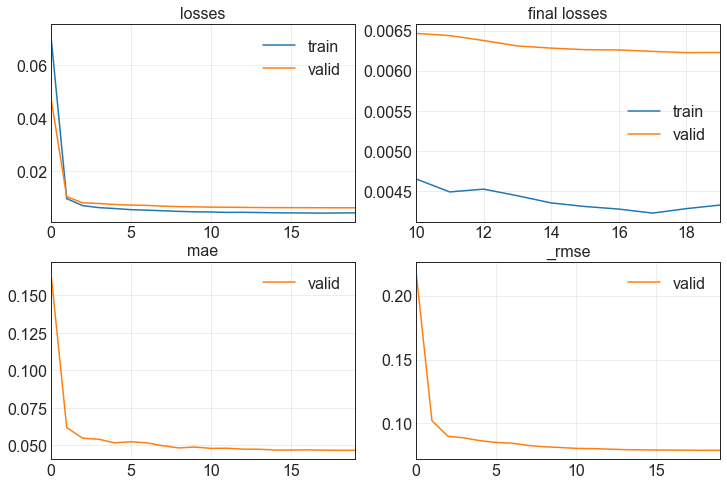

172.494234085083                                                                                                       
[0.004322932101786137, 0.006227548699826002, 0.046762507408857346, 0.0789148360490799]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 55%|██████████████████████                  | 55/100 [1:43:49<1:23:20, 111.12s/trial, best loss: 0.005212754476815462]

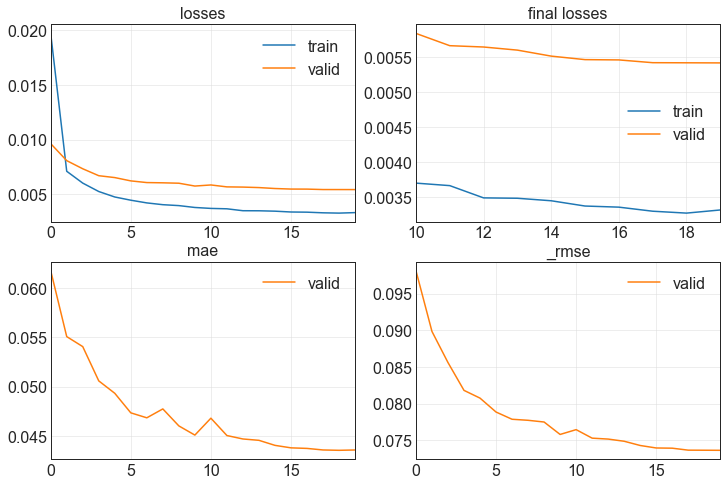

68.98439002037048                                                                                                      
[0.0033127523493021727, 0.005421042907983065, 0.04356846585869789, 0.07362773269414902]                                
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 56%|██████████████████████▉                  | 56/100 [1:44:59<1:12:27, 98.81s/trial, best loss: 0.005212754476815462]

No improvement since epoch 46: early stopping                                                                          
 56%|██████████████████████▉                  | 56/100 [1:46:16<1:12:27, 98.81s/trial, best loss: 0.005212754476815462]

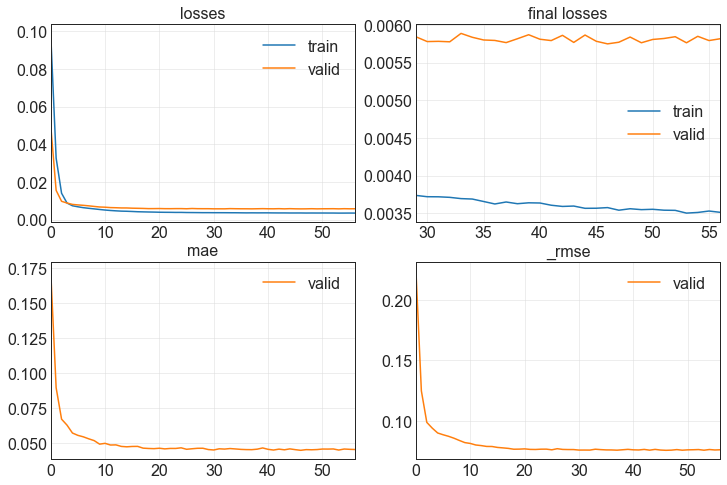

77.50411915779114                                                                                                      
[0.003514339681714773, 0.005816018674522638, 0.045631978660821915, 0.07626282423734665]                                
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 57%|███████████████████████▎                 | 57/100 [1:46:17<1:06:28, 92.76s/trial, best loss: 0.005212754476815462]

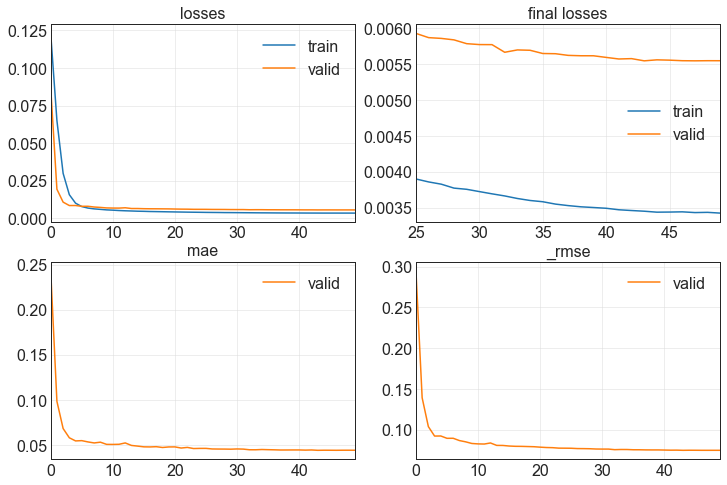

34.76852369308472                                                                                                      
[0.0034222817048430443, 0.005546236876398325, 0.044100143015384674, 0.0744730606675148]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 58%|████████████████████████▉                  | 58/100 [1:46:53<52:58, 75.69s/trial, best loss: 0.005212754476815462]

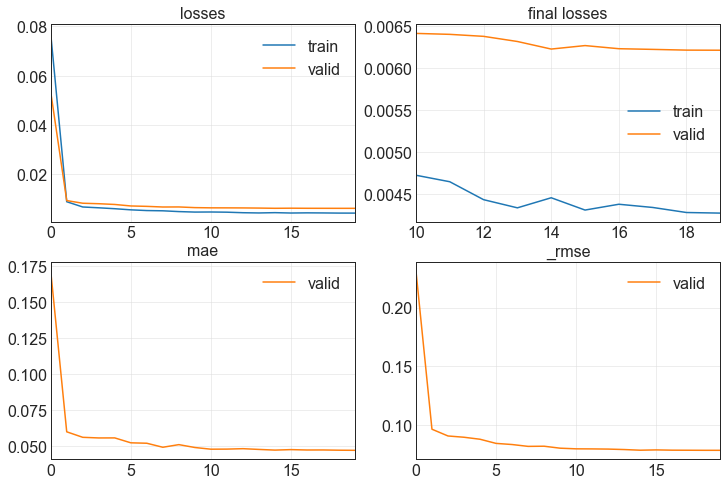

103.56148719787598                                                                                                     
[0.0042782314121723175, 0.006215288303792477, 0.04688576981425285, 0.07883710414171219]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 59%|█████████████████████████▎                 | 59/100 [1:48:38<57:39, 84.37s/trial, best loss: 0.005212754476815462]

No improvement since epoch 1: early stopping                                                                           
 59%|█████████████████████████▎                 | 59/100 [1:50:25<57:39, 84.37s/trial, best loss: 0.005212754476815462]

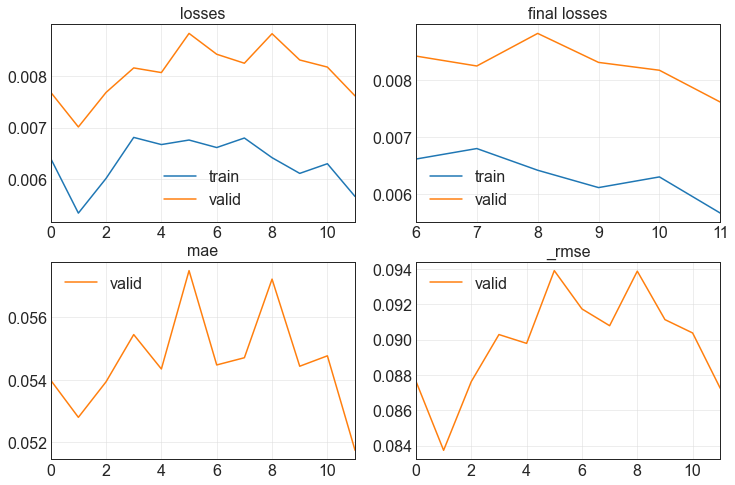

107.44131898880005                                                                                                     
[0.00566801568493247, 0.007611336186528206, 0.051748450845479965, 0.0872429683804512]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.1, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 60%|████████████████████████▌                | 60/100 [1:50:26<1:01:05, 91.63s/trial, best loss: 0.005212754476815462]

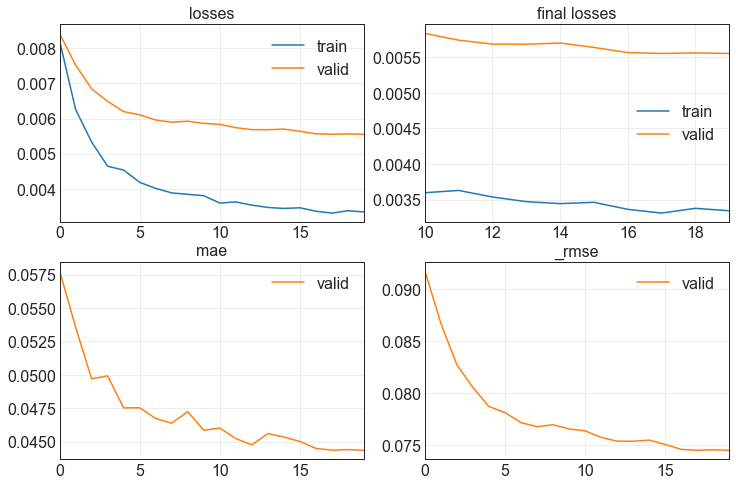

143.65054273605347                                                                                                     
[0.003342533018440008, 0.0055520422756671906, 0.04435546696186066, 0.07451201975345612]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 61%|████████████████████████▍               | 61/100 [1:52:51<1:09:55, 107.57s/trial, best loss: 0.005212754476815462]

No improvement since epoch 53: early stopping                                                                          
 61%|████████████████████████▍               | 61/100 [1:55:36<1:09:55, 107.57s/trial, best loss: 0.005212754476815462]

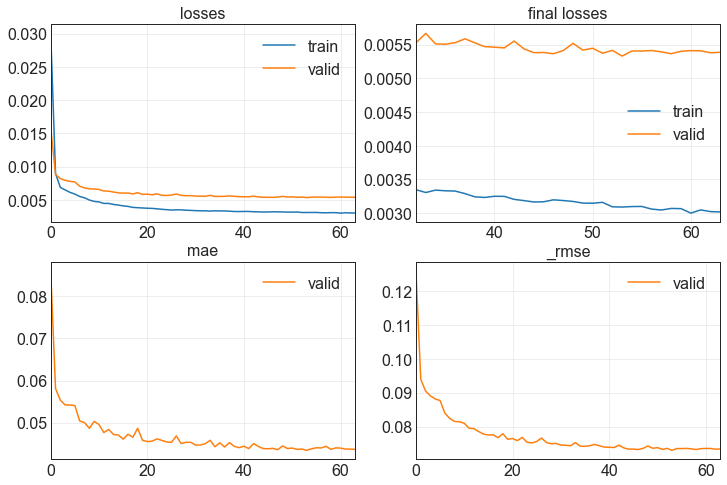

165.3011794090271                                                                                                      
[0.00301819434389472, 0.0053873020224273205, 0.04364756867289543, 0.07339824736118317]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.5, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 62%|████████████████████████▊               | 62/100 [1:55:38<1:19:18, 125.22s/trial, best loss: 0.005212754476815462]

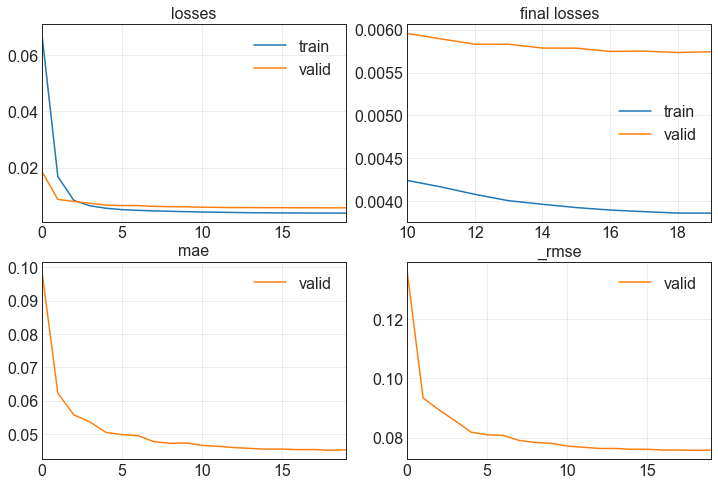

27.37945556640625                                                                                                      
[0.003863810794427991, 0.005741367116570473, 0.045220304280519485, 0.07577181607484818]                                
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 63%|███████████████████████████                | 63/100 [1:56:06<59:19, 96.20s/trial, best loss: 0.005212754476815462]

No improvement since epoch 9: early stopping                                                                           
 63%|███████████████████████████                | 63/100 [1:56:16<59:19, 96.20s/trial, best loss: 0.005212754476815462]

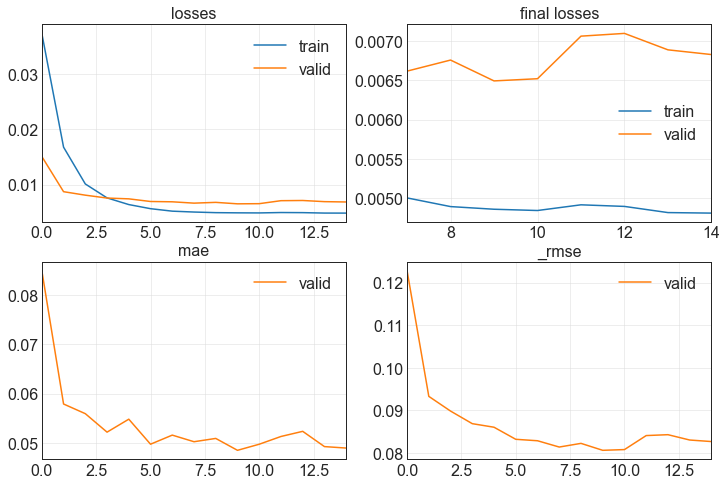

10.73221731185913                                                                                                      
[0.0048077963292598724, 0.006829359102994204, 0.04894817993044853, 0.08263993263244629]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 64%|███████████████████████████▌               | 64/100 [1:56:18<42:32, 70.89s/trial, best loss: 0.005212754476815462]

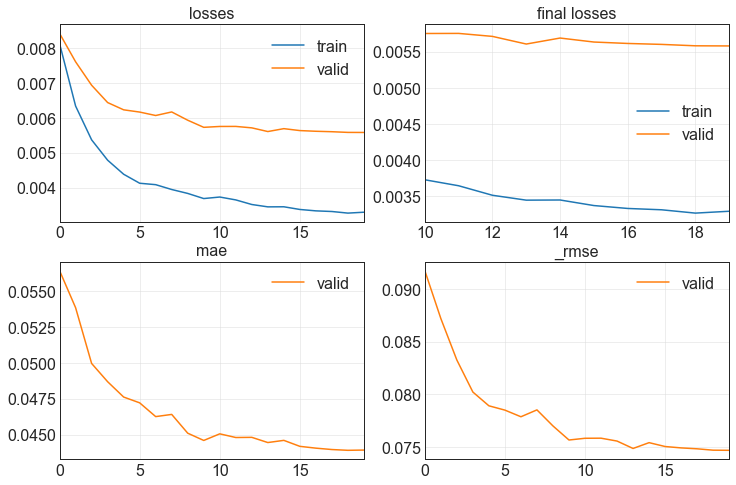

103.76532673835754                                                                                                     
[0.0032935000490397215, 0.005577870178967714, 0.04392439126968384, 0.07468514144420624]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 65%|███████████████████████████▉               | 65/100 [1:58:03<47:17, 81.08s/trial, best loss: 0.005212754476815462]

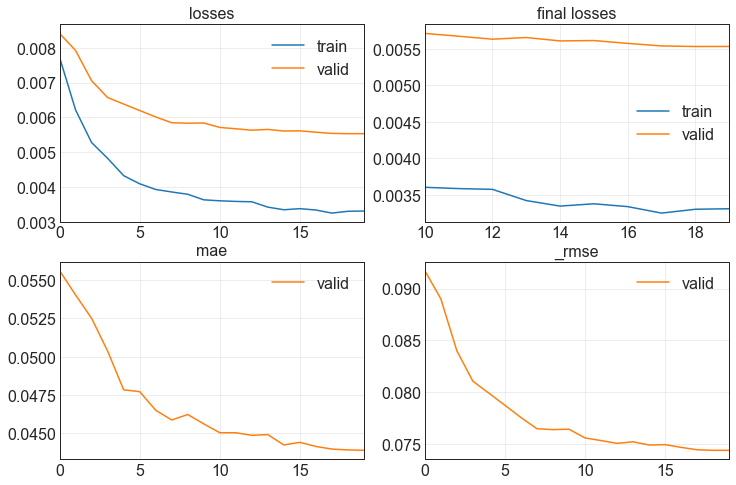

103.38711857795715                                                                                                     
[0.003309497144073248, 0.005534064024686813, 0.04389137029647827, 0.07439129799604416]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 66%|████████████████████████████▍              | 66/100 [1:59:47<49:55, 88.11s/trial, best loss: 0.005212754476815462]

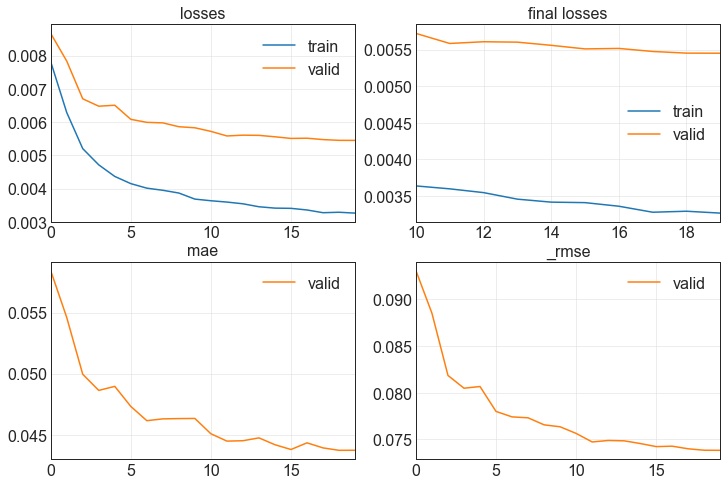

103.63560748100281                                                                                                     
[0.003266032552346587, 0.005451291333884001, 0.043728429824113846, 0.07383286952972412]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 67%|████████████████████████████▊              | 67/100 [2:01:32<51:12, 93.10s/trial, best loss: 0.005212754476815462]

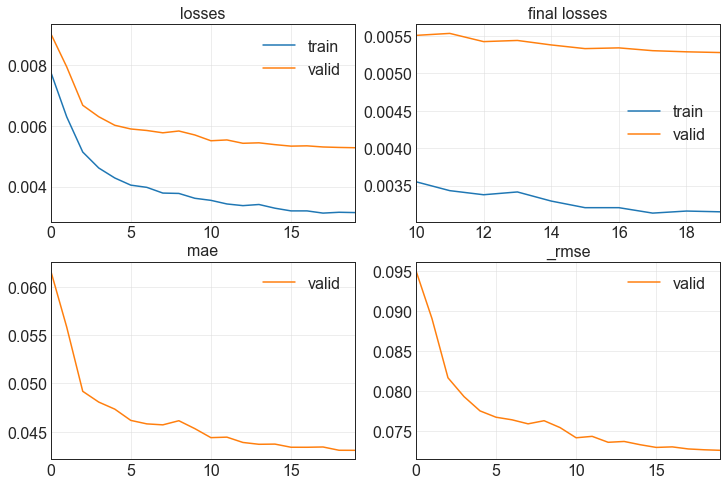

103.62856578826904                                                                                                     
[0.0031494470313191414, 0.005278685595840216, 0.04308829829096794, 0.07265456765890121]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 68%|█████████████████████████████▏             | 68/100 [2:03:17<51:30, 96.59s/trial, best loss: 0.005212754476815462]

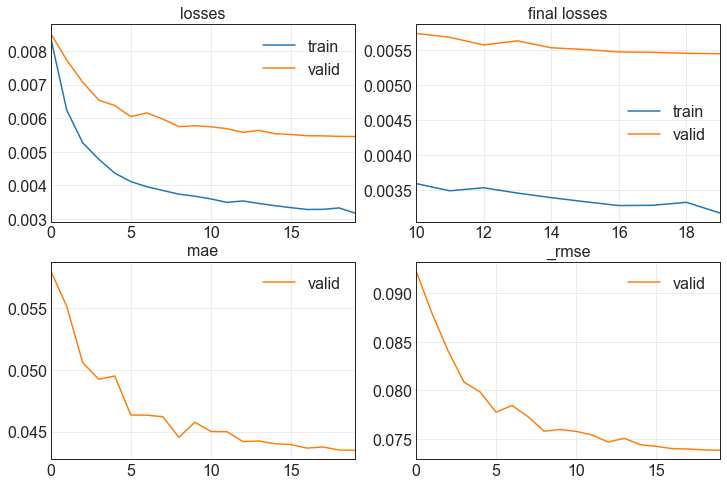

103.5330548286438                                                                                                      
[0.003174344776198268, 0.005453362595289946, 0.04349078983068466, 0.07384689152240753]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 69%|█████████████████████████████▋             | 69/100 [2:05:01<51:09, 99.00s/trial, best loss: 0.005212754476815462]

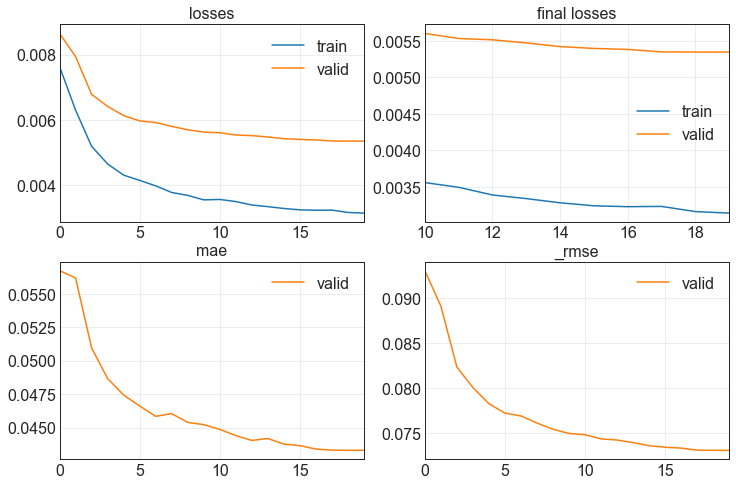

103.50418186187744                                                                                                     
[0.003141365945339203, 0.005348508246243, 0.04330078512430191, 0.07313349097967148]                                    
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 70%|█████████████████████████████▍            | 70/100 [2:06:46<50:20, 100.69s/trial, best loss: 0.005212754476815462]

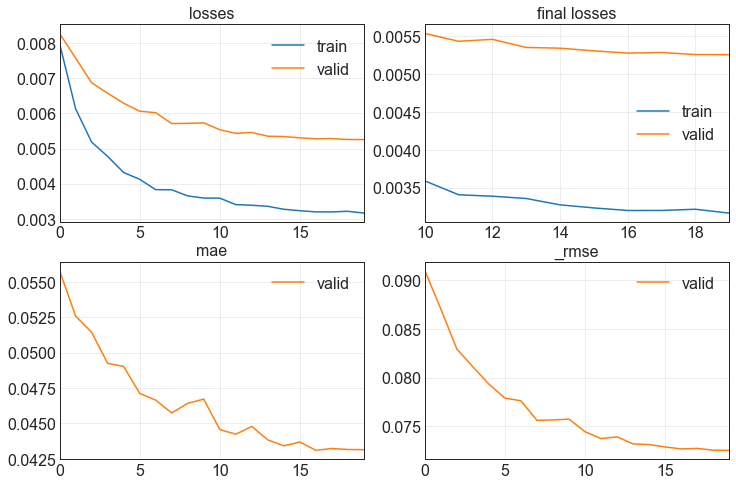

103.55176281929016                                                                                                     
[0.0031624375842511654, 0.005257138051092625, 0.04314832389354706, 0.0725061222910881]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 71%|█████████████████████████████▊            | 71/100 [2:08:31<49:14, 101.88s/trial, best loss: 0.005212754476815462]

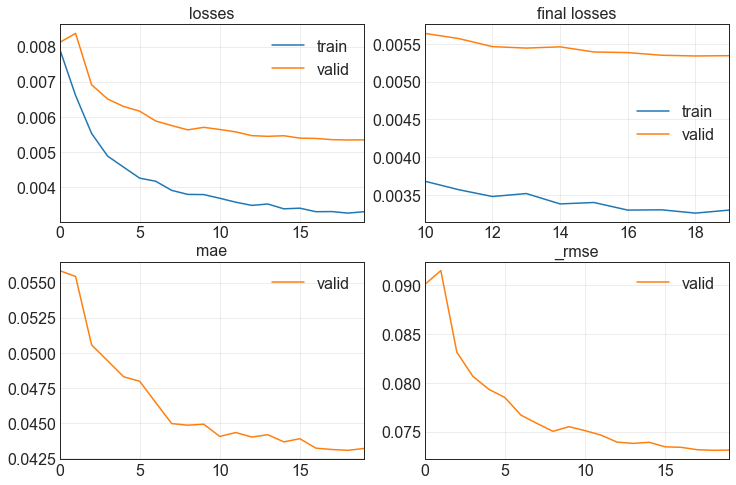

103.66414189338684                                                                                                     
[0.0032962849363684654, 0.005343553144484758, 0.04318661242723465, 0.07309961318969727]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 72%|██████████████████████████████▏           | 72/100 [2:10:15<47:56, 102.74s/trial, best loss: 0.005212754476815462]

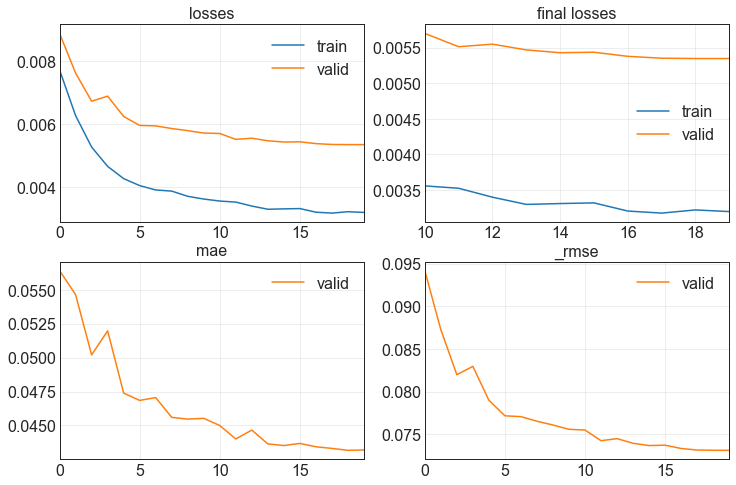

103.78089952468872                                                                                                     
[0.003196355188265443, 0.005346156191080809, 0.04319312050938606, 0.07311742007732391]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 73%|██████████████████████████████▋           | 73/100 [2:12:00<46:31, 103.38s/trial, best loss: 0.005212754476815462]

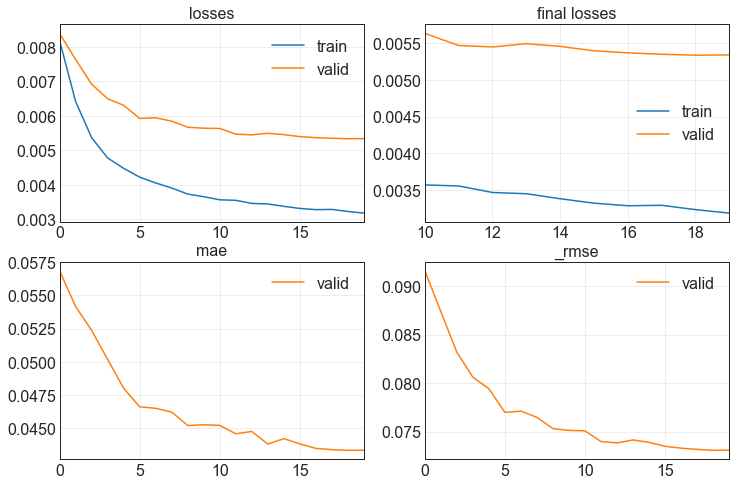

103.58361530303955                                                                                                     
[0.003182546701282263, 0.005342890042811632, 0.043356914073228836, 0.07309507578611374]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.1, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 74%|███████████████████████████████           | 74/100 [2:13:45<44:58, 103.78s/trial, best loss: 0.005212754476815462]

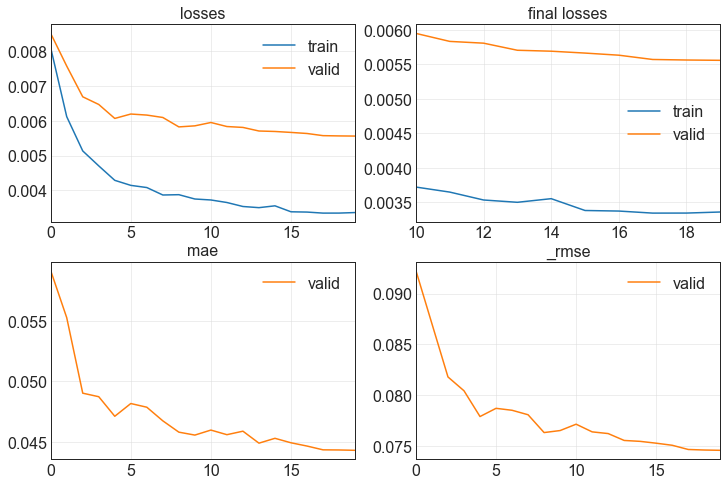

106.70131063461304                                                                                                     
[0.003359216032549739, 0.005559337791055441, 0.04429313912987709, 0.07456096261739731]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 75%|███████████████████████████████▌          | 75/100 [2:15:33<43:44, 104.98s/trial, best loss: 0.005212754476815462]

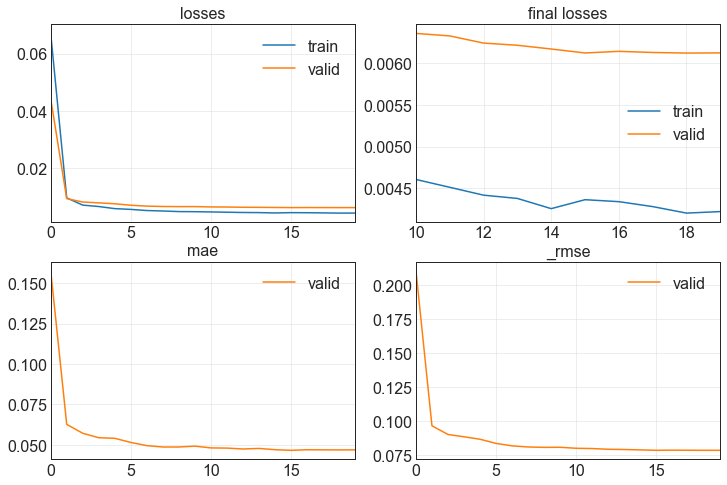

179.02889609336853                                                                                                     
[0.0042189545929431915, 0.006126026157289743, 0.04684530943632126, 0.07826893031597137]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 76%|███████████████████████████████▉          | 76/100 [2:18:33<51:00, 127.53s/trial, best loss: 0.005212754476815462]

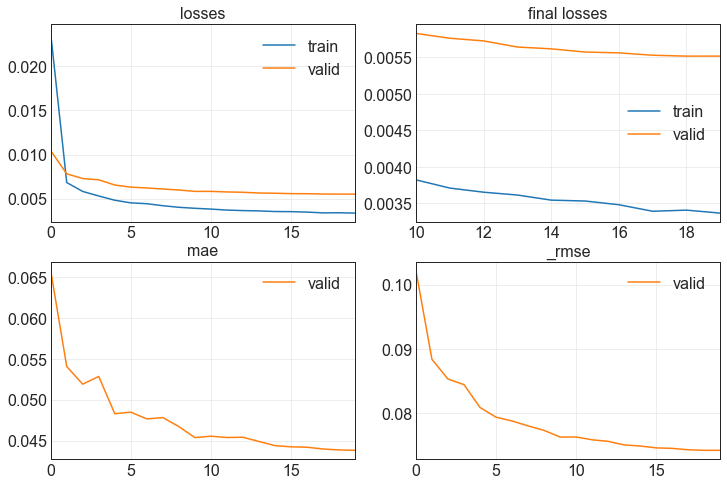

52.189011335372925                                                                                                     
[0.0033653315622359514, 0.005515645258128643, 0.04379938170313835, 0.07426738739013672]                                
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 77%|████████████████████████████████▎         | 77/100 [2:19:26<40:20, 105.26s/trial, best loss: 0.005212754476815462]

No improvement since epoch 27: early stopping                                                                          
 77%|████████████████████████████████▎         | 77/100 [2:20:35<40:20, 105.26s/trial, best loss: 0.005212754476815462]

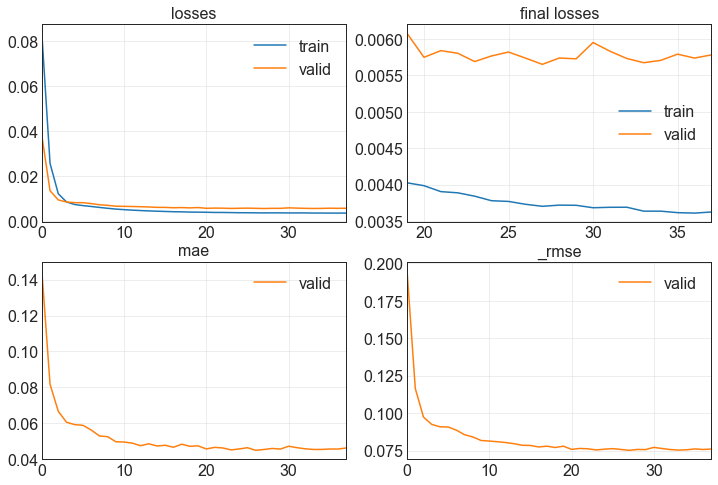

68.64849972724915                                                                                                      
[0.003624760312959552, 0.005780193954706192, 0.04611782357096672, 0.07602758705615997]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 78%|█████████████████████████████████▌         | 78/100 [2:20:36<34:41, 94.61s/trial, best loss: 0.005212754476815462]

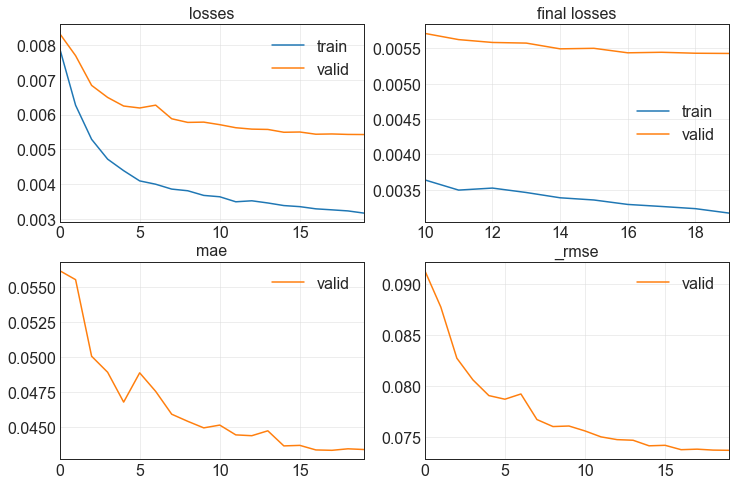

103.609543800354                                                                                                       
[0.003170137759298086, 0.005429851356893778, 0.04336847737431526, 0.07368753105401993]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 79%|█████████████████████████████████▉         | 79/100 [2:22:21<34:10, 97.64s/trial, best loss: 0.005212754476815462]

No improvement since epoch 11: early stopping                                                                          
 79%|█████████████████████████████████▉         | 79/100 [2:22:36<34:10, 97.64s/trial, best loss: 0.005212754476815462]

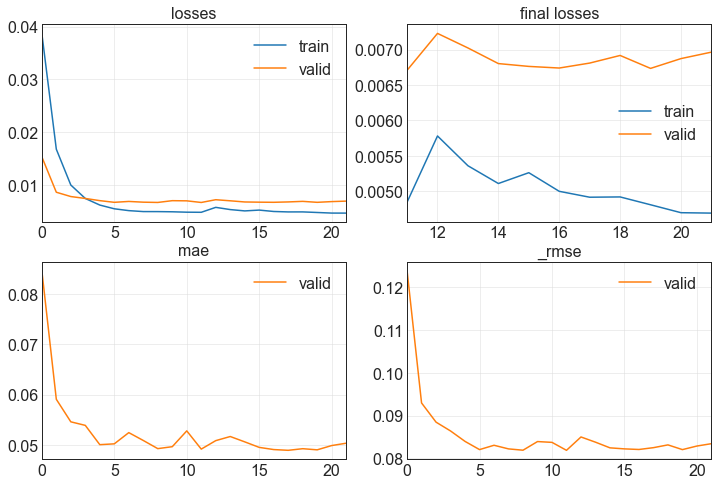

15.500314712524414                                                                                                     
[0.004693727474659681, 0.006964121945202351, 0.050344068557024, 0.08345132321119308]                                   
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.1, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 80%|██████████████████████████████████▍        | 80/100 [2:22:37<24:26, 73.33s/trial, best loss: 0.005212754476815462]

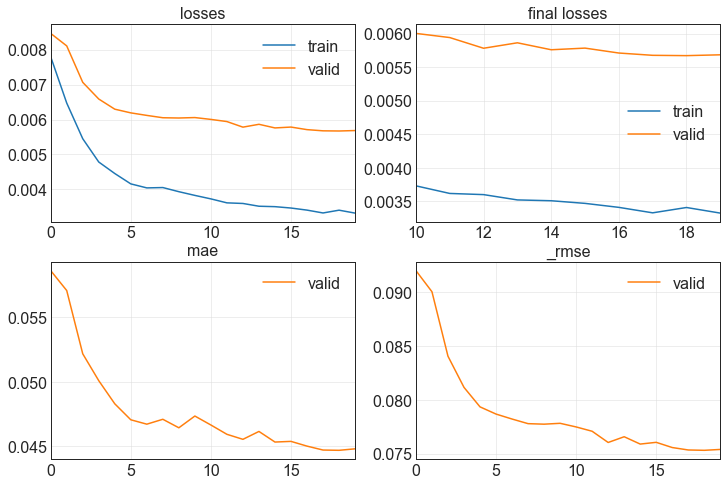

178.908549785614                                                                                                       
[0.0033238644246011972, 0.005684109404683113, 0.0447976179420948, 0.07539303600788116]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 81%|██████████████████████████████████        | 81/100 [2:25:37<33:21, 105.33s/trial, best loss: 0.005212754476815462]

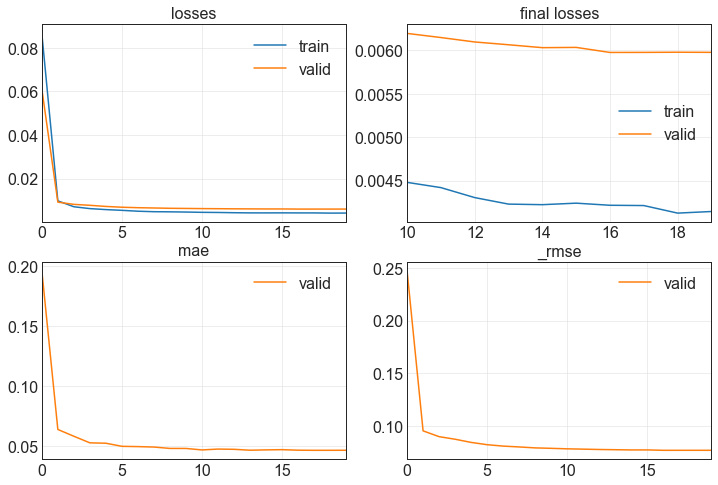

107.09966826438904                                                                                                     
[0.004145416896790266, 0.005977817811071873, 0.04628458991646767, 0.07731634378433228]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 82%|██████████████████████████████████▍       | 82/100 [2:27:26<31:51, 106.19s/trial, best loss: 0.005212754476815462]

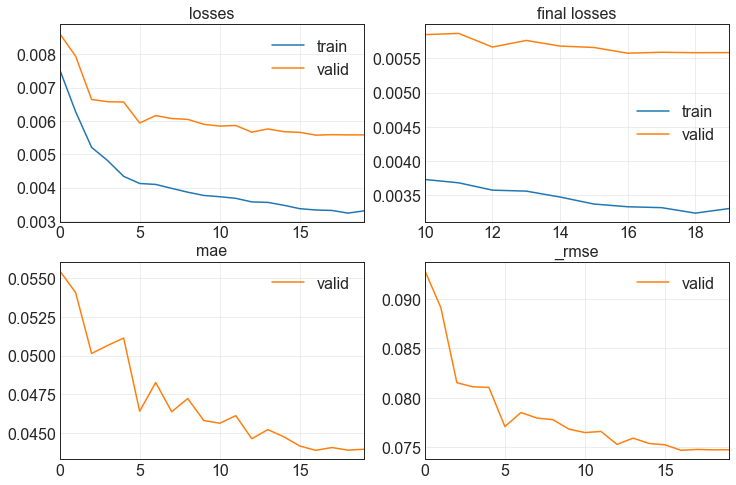

139.38332533836365                                                                                                     
[0.003304567188024521, 0.00558505579829216, 0.04395533725619316, 0.07473322749137878]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 10}
TCN                                                                                                                    
 83%|██████████████████████████████████▊       | 83/100 [2:29:46<33:00, 116.48s/trial, best loss: 0.005212754476815462]

No improvement since epoch 35: early stopping                                                                          
 83%|██████████████████████████████████▊       | 83/100 [2:31:48<33:00, 116.48s/trial, best loss: 0.005212754476815462]

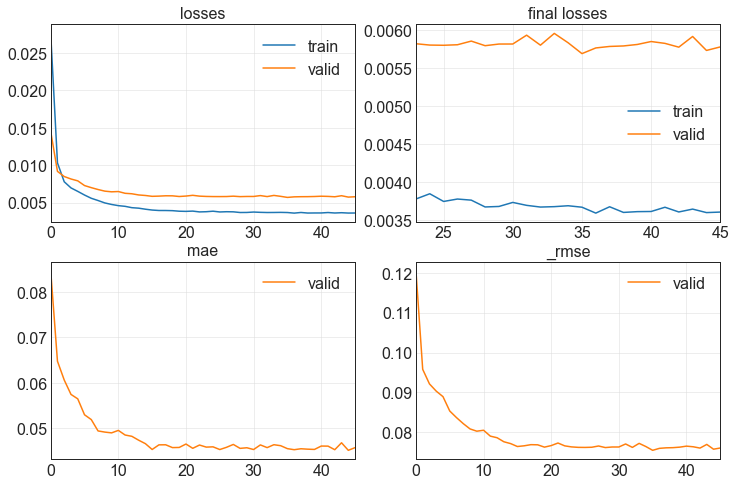

122.61267352104187                                                                                                     
[0.0036068595945835114, 0.0057813492603600025, 0.04576307162642479, 0.07603518664836884]                               
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 84%|███████████████████████████████████▎      | 84/100 [2:31:50<31:38, 118.65s/trial, best loss: 0.005212754476815462]

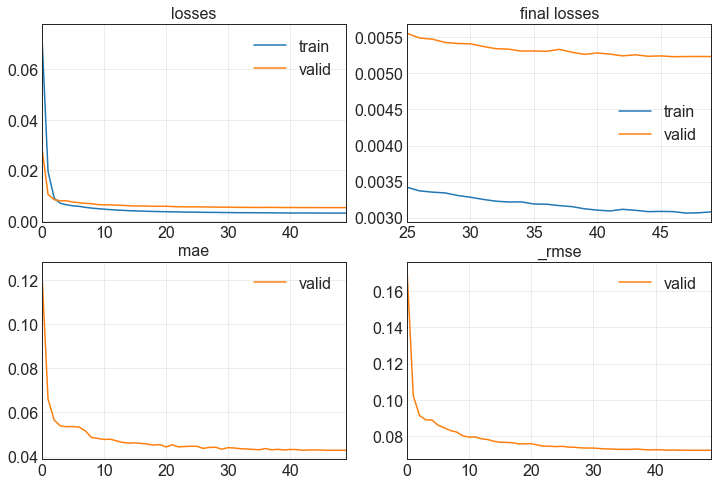

66.02228116989136                                                                                                      
[0.0030804299749433994, 0.005234440788626671, 0.04287765920162201, 0.0723494365811348]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 85%|███████████████████████████████████▋      | 85/100 [2:32:57<25:47, 103.19s/trial, best loss: 0.005212754476815462]

No improvement since epoch 6: early stopping                                                                           
 85%|███████████████████████████████████▋      | 85/100 [2:33:13<25:47, 103.19s/trial, best loss: 0.005212754476815462]

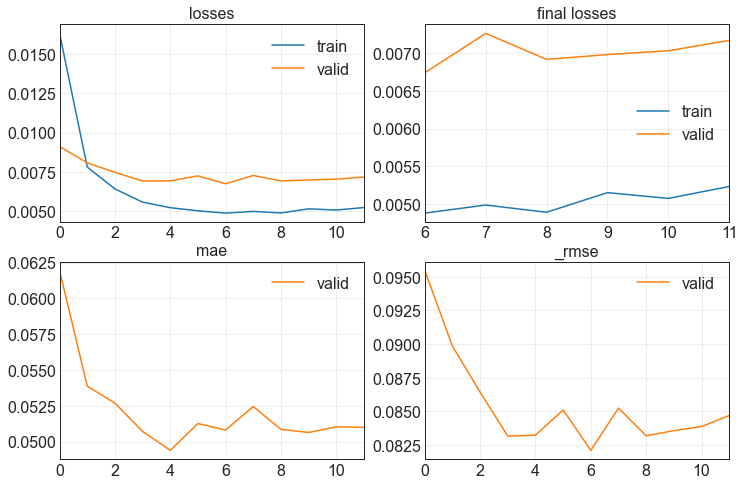

16.23626947402954                                                                                                      
[0.005229248199611902, 0.007173154037445784, 0.05099773779511452, 0.08469446748495102]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 86%|████████████████████████████████████▉      | 86/100 [2:33:14<18:04, 77.44s/trial, best loss: 0.005212754476815462]

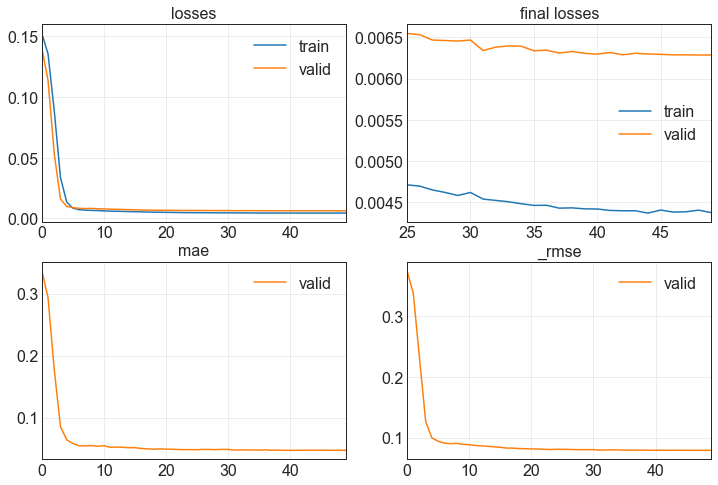

109.07670783996582                                                                                                     
[0.004372702445834875, 0.006286074407398701, 0.047134846448898315, 0.07928477227687836]                                
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 87%|█████████████████████████████████████▍     | 87/100 [2:35:04<18:54, 87.26s/trial, best loss: 0.005212754476815462]

No improvement since epoch 42: early stopping                                                                          
 87%|█████████████████████████████████████▍     | 87/100 [2:36:31<18:54, 87.26s/trial, best loss: 0.005212754476815462]

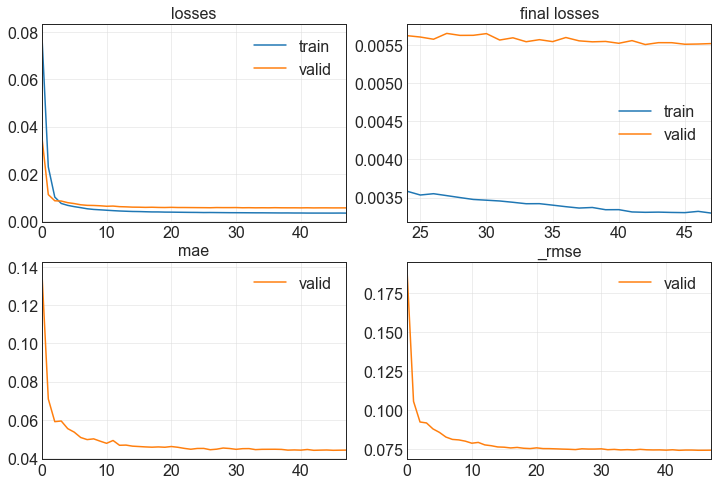

86.73833227157593                                                                                                      
[0.003297102637588978, 0.0055181835778057575, 0.04408317804336548, 0.07428447902202606]                                
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.1, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 88%|█████████████████████████████████████▊     | 88/100 [2:36:32<17:29, 87.44s/trial, best loss: 0.005212754476815462]

No improvement since epoch 31: early stopping                                                                          
 88%|█████████████████████████████████████▊     | 88/100 [2:37:23<17:29, 87.44s/trial, best loss: 0.005212754476815462]

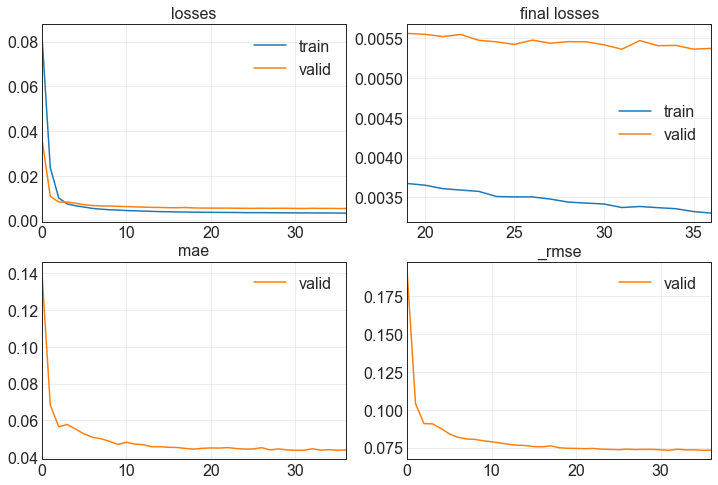

50.961907625198364                                                                                                     
[0.0033038086257874966, 0.005370865110307932, 0.04387093707919121, 0.07328619062900543]                                
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 89%|██████████████████████████████████████▎    | 89/100 [2:37:24<14:05, 76.83s/trial, best loss: 0.005212754476815462]

No improvement since epoch 35: early stopping                                                                          
 89%|██████████████████████████████████████▎    | 89/100 [2:38:18<14:05, 76.83s/trial, best loss: 0.005212754476815462]

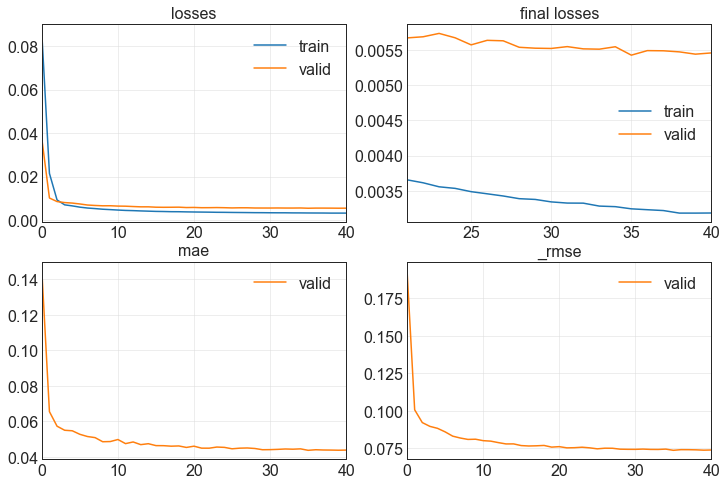

54.44611120223999                                                                                                      
[0.0031873686239123344, 0.005457088351249695, 0.04382309317588806, 0.07387211173772812]                                
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.5, 'epochs': 50, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 90%|██████████████████████████████████████▋    | 90/100 [2:38:20<11:44, 70.45s/trial, best loss: 0.005212754476815462]

No improvement since epoch 6: early stopping                                                                           
 90%|██████████████████████████████████████▋    | 90/100 [2:38:36<11:44, 70.45s/trial, best loss: 0.005212754476815462]

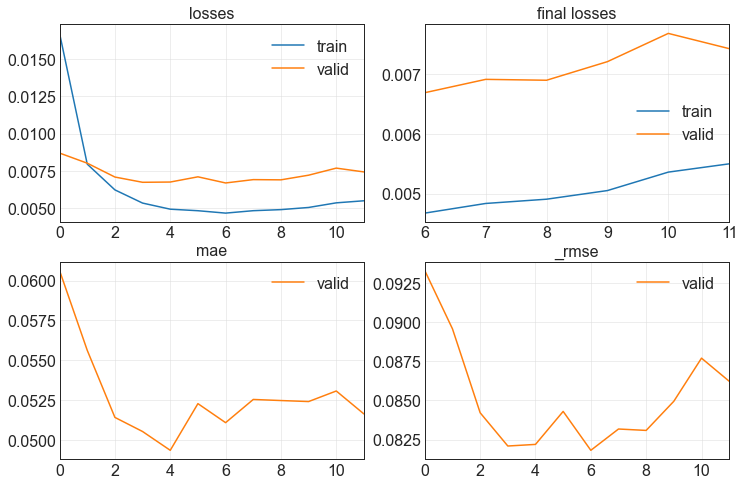

16.60738468170166                                                                                                      
[0.005498387850821018, 0.007433666381984949, 0.05162699520587921, 0.0862187072634697]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 91%|███████████████████████████████████████▏   | 91/100 [2:38:38<08:11, 54.63s/trial, best loss: 0.005212754476815462]

No improvement since epoch 27: early stopping                                                                          
 91%|███████████████████████████████████████▏   | 91/100 [2:39:49<08:11, 54.63s/trial, best loss: 0.005212754476815462]

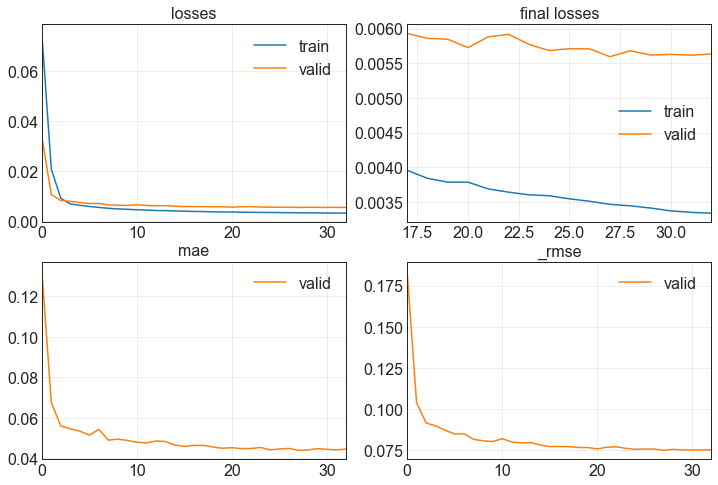

71.97843933105469                                                                                                      
[0.0033362542744725943, 0.005633363965898752, 0.044603269547224045, 0.07505574077367783]                               
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 92%|███████████████████████████████████████▌   | 92/100 [2:39:51<08:01, 60.17s/trial, best loss: 0.005212754476815462]

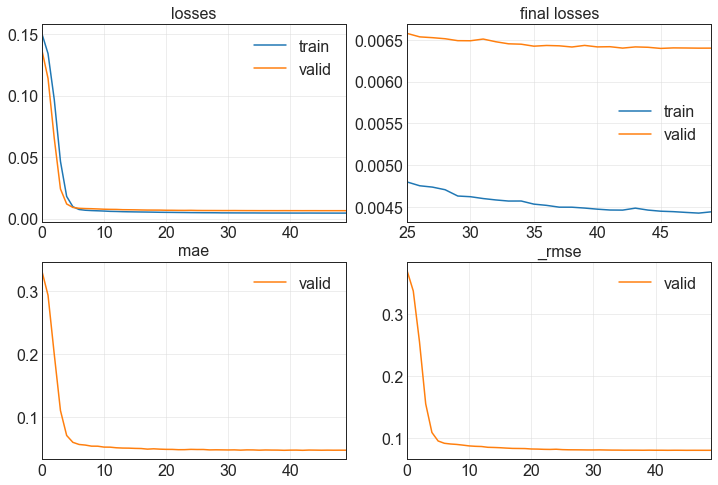

65.90227198600769                                                                                                      
[0.004439148120582104, 0.006399872712790966, 0.047587841749191284, 0.07999920099973679]                                
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 93%|███████████████████████████████████████▉   | 93/100 [2:40:58<07:15, 62.22s/trial, best loss: 0.005212754476815462]

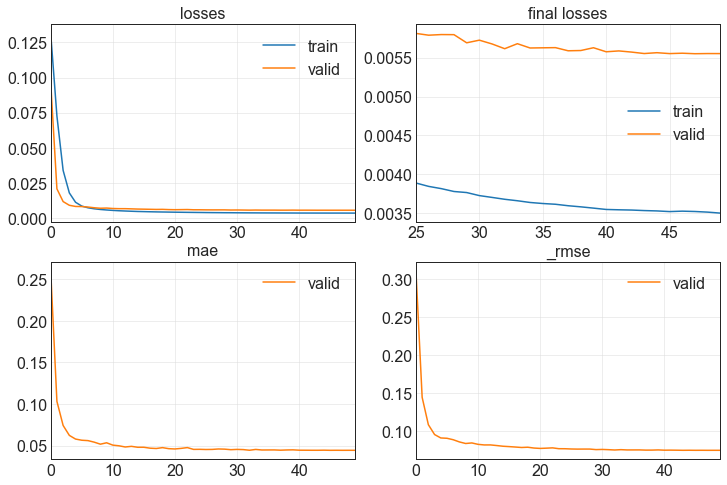

47.352067947387695                                                                                                     
[0.0034997223410755396, 0.005552556831389666, 0.04432503506541252, 0.07451547682285309]                                
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.1, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 94%|████████████████████████████████████████▍  | 94/100 [2:41:46<05:48, 58.10s/trial, best loss: 0.005212754476815462]

No improvement since epoch 44: early stopping                                                                          
 94%|████████████████████████████████████████▍  | 94/100 [2:42:54<05:48, 58.10s/trial, best loss: 0.005212754476815462]

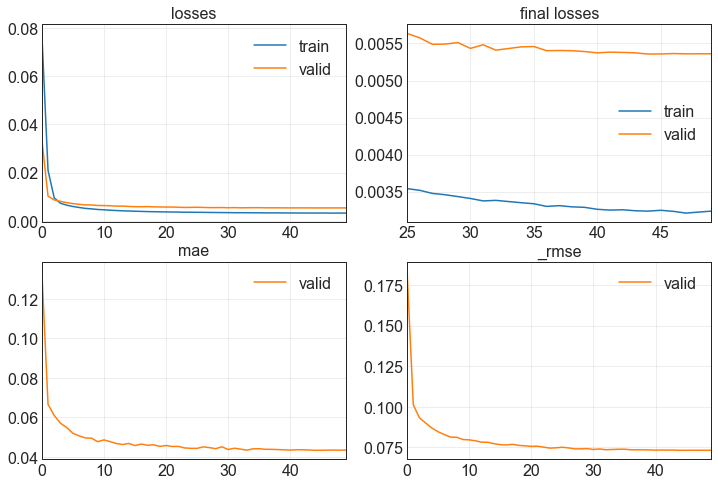

67.8836350440979                                                                                                       
[0.003237090539187193, 0.0053612538613379, 0.04349340870976448, 0.07322058081626892]                                   
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 95%|████████████████████████████████████████▊  | 95/100 [2:42:55<05:06, 61.36s/trial, best loss: 0.005212754476815462]

No improvement since epoch 37: early stopping                                                                          
 95%|████████████████████████████████████████▊  | 95/100 [2:44:46<05:06, 61.36s/trial, best loss: 0.005212754476815462]

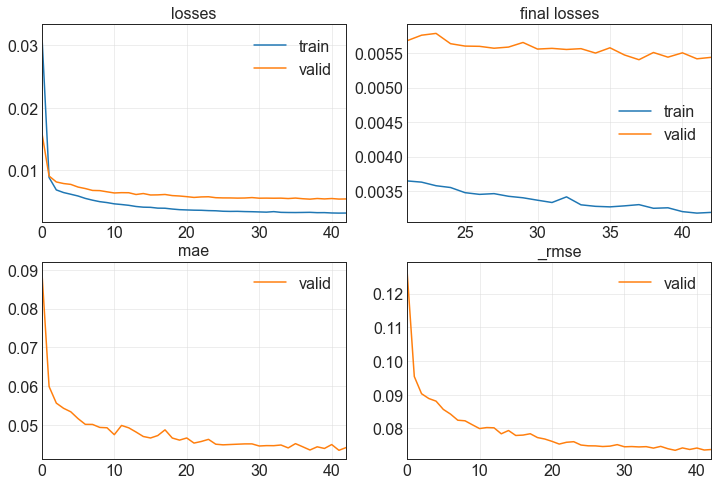

111.420339345932                                                                                                       
[0.0031889271922409534, 0.005441633518785238, 0.044120755046606064, 0.07376743108034134]                               
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 96%|█████████████████████████████████████████▎ | 96/100 [2:44:48<05:06, 76.71s/trial, best loss: 0.005212754476815462]

No improvement since epoch 6: early stopping                                                                           
 96%|█████████████████████████████████████████▎ | 96/100 [2:45:03<05:06, 76.71s/trial, best loss: 0.005212754476815462]

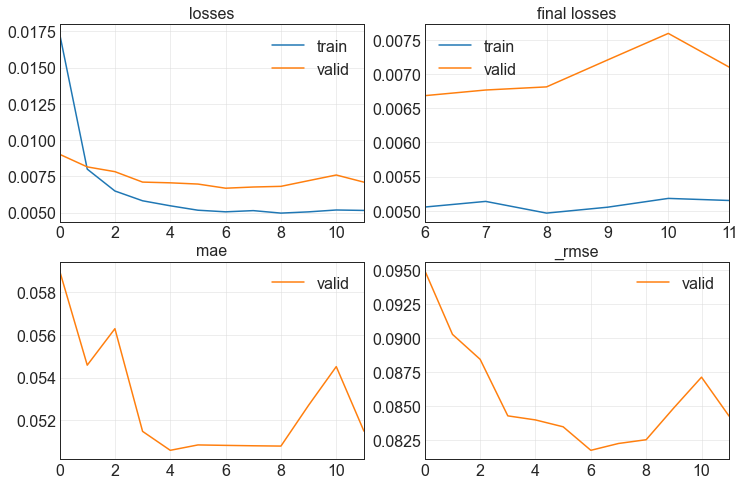

16.23021388053894                                                                                                      
[0.005151070188730955, 0.00709949666634202, 0.0514925979077816, 0.08425851911306381]                                   
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.5, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 97%|█████████████████████████████████████████▋ | 97/100 [2:45:05<02:56, 58.89s/trial, best loss: 0.005212754476815462]

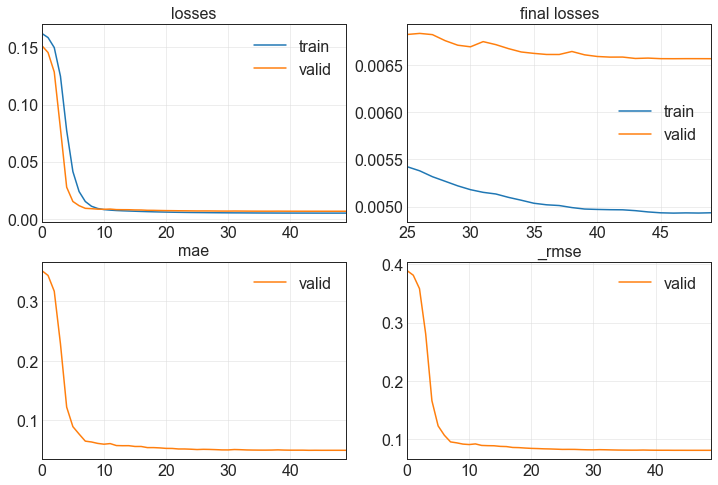

59.061034202575684                                                                                                     
[0.004935827571898699, 0.006565252784639597, 0.04927676543593407, 0.08102624118328094]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 98%|██████████████████████████████████████████▏| 98/100 [2:46:05<01:58, 59.28s/trial, best loss: 0.005212754476815462]

No improvement since epoch 44: early stopping                                                                          
 98%|██████████████████████████████████████████▏| 98/100 [2:47:12<01:58, 59.28s/trial, best loss: 0.005212754476815462]

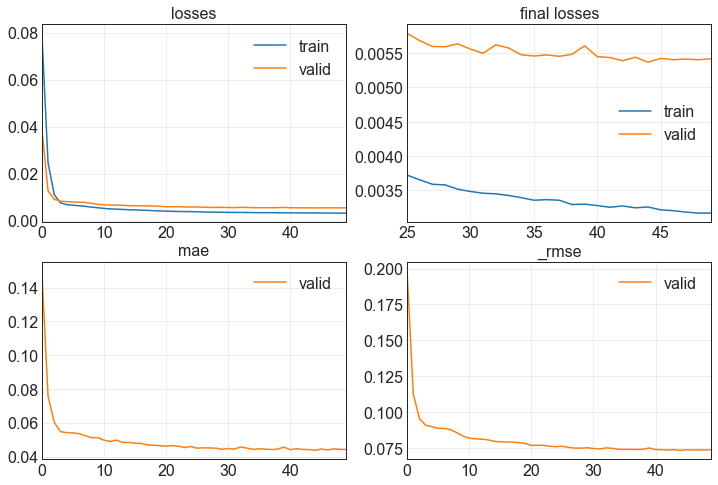

66.80561637878418                                                                                                      
[0.003168993629515171, 0.005418288055807352, 0.04411961883306503, 0.07360902428627014]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}
TCN                                                                                                                    
 99%|██████████████████████████████████████████▌| 99/100 [2:47:13<01:01, 61.87s/trial, best loss: 0.005212754476815462]

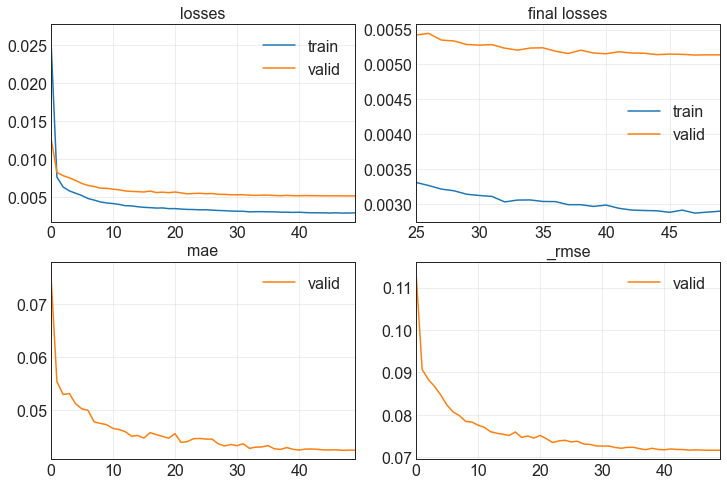

171.05802702903748                                                                                                     
[0.0028976143803447485, 0.005137521307915449, 0.04237551987171173, 0.07167649269104004]                                
100%|█████████████████████████████████████████| 100/100 [2:50:04<00:00, 102.05s/trial, best loss: 0.005137521307915449]


In [57]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=max_evals,  # test trials
    trials=trials)

In [58]:
print("Best parameters:")
print(space_eval(search_space, best))
params = space_eval(search_space, best)

Best parameters:
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000001E592C94438>, 'patience': 5}


In [59]:
# only for debug
# params = {'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': Adam, 'patience': 10}

# Retrain the model with best hyperparameter

We use training data for training and validation data for (possible) early stopping:

In [60]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [61]:
X.shape

(7990, 196, 10)

In [62]:
y.shape

(7990, 196)

In [63]:
batch_size = params["batch_size"]

In [64]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# set num_workers for memory bottleneck
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)

Create the model:

In [65]:
arch = TCN
k = {
    'layers': params['layers'],
    'ks': params['ks'],
    'conv_dropout': params['conv_dropout']
}
model = create_model(arch, dls=dls, **k)
print(model.__class__.__name__)

TCN


In [66]:
# Add a Sigmoid layer
model = nn.Sequential(model, nn.Sigmoid())

In [67]:
model

Sequential(
  (0): TCN(
    (tcn): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(196, 25, kernel_size=(7,), stride=(1,), padding=(6,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.0, inplace=False)
        (conv2): Conv1d(25, 25, kernel_size=(7,), stride=(1,), padding=(6,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.0, inplace=False)
        (net): Sequential(
          (0): Conv1d(196, 25, kernel_size=(7,), stride=(1,), padding=(6,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.0, inplace=False)
          (4): Conv1d(25, 25, kernel_size=(7,), stride=(1,), padding=(6,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.0, inplace=False)
        )
        (downsample): Conv1d(196, 25, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1d(25, 25, kernel_size=(7,), stride=(1,), padding

In [68]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

93,046 total parameters.
93,046 training parameters.


Training the model:

No improvement since epoch 44: early stopping


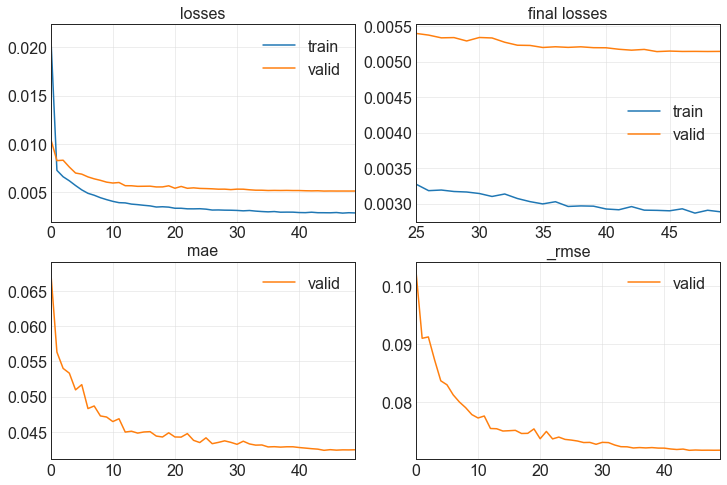

In [69]:
learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
start = time.time()
learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                    cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
training_time = time.time() - start
learn.plot_metrics()

Evaluate the model:

In [70]:
dls = learn.dls
valid_dl = dls.valid

In [71]:
test_ds = valid_dl.dataset.add_test(X_test, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

1999


In [72]:
start = time.time()
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
prediction_time = time.time() - start
test_probas, test_targets, test_preds

(tensor([[6.9081e-01, 1.4043e-01, 6.8652e-01,  ..., 4.9045e-01, 6.8806e-04,
          5.2943e-04],
         [6.9636e-01, 1.4754e-01, 6.9278e-01,  ..., 4.8905e-01, 6.9830e-04,
          5.5317e-04],
         [7.2767e-01, 1.6554e-01, 7.0084e-01,  ..., 4.8405e-01, 8.4809e-04,
          7.2097e-04],
         ...,
         [7.9538e-01, 1.9235e-01, 6.7501e-01,  ..., 5.7308e-01, 1.3605e-03,
          1.4399e-03],
         [8.0759e-01, 2.0629e-01, 6.7435e-01,  ..., 5.7014e-01, 1.7410e-03,
          1.7982e-03],
         [8.0295e-01, 2.0532e-01, 6.7365e-01,  ..., 5.4807e-01, 2.0100e-03,
          2.0387e-03]]),
 tensor([[0.7516, 0.2175, 0.7770,  ..., 0.5197, 0.0000, 0.0000],
         [0.7553, 0.2080, 0.7623,  ..., 0.5126, 0.0000, 0.0000],
         [0.7457, 0.1962, 0.7510,  ..., 0.4877, 0.0000, 0.0000],
         ...,
         [0.7723, 0.1825, 0.6382,  ..., 0.6950, 0.0000, 0.0000],
         [0.7608, 0.1724, 0.6434,  ..., 0.6812, 0.0000, 0.0000],
         [0.7262, 0.1734, 0.6523,  ..., 0.6877, 0.0

In [73]:
test_targets.shape

torch.Size([1999, 196])

In [74]:
test_preds.shape

torch.Size([1999, 196])

In [75]:
y_true = test_targets.numpy()
y_pred = test_preds.numpy()

Reshape the data into multiple steps

In [76]:
y_true = y_true.reshape(y_true.shape[0], horizon, -1)
y_pred = y_pred.reshape(y_pred.shape[0], horizon, -1)

In [77]:
y_true.shape

(1999, 1, 196)

In [78]:
y_pred.shape

(1999, 1, 196)

Transform the data in the normal range:

In [79]:
def inverse_normalization(prediction, y, max_list, min_list):
    inverse_prediction = prediction * (max_list - min_list) + min_list
    inverse_y = y * (max_list - min_list) + min_list

    return inverse_prediction, inverse_y

In [80]:
y_true_list = []
y_pred_list = []
for i in range(y_true.shape[0]):
    y_true_tmp = []
    y_pred_tmp = []
    for step in range(y_true.shape[1]):
        inverse_prediction, inverse_y = inverse_normalization(y_pred[i, step, :], y_true[i, step, :], max_list, min_list)
        
        y_true_tmp.append(inverse_y)
        y_pred_tmp.append(inverse_prediction)
    y_true_list.append(y_true_tmp)
    y_pred_list.append(y_pred_tmp)

In [81]:
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

In [82]:
y_true.shape

(1999, 1, 196)

In [83]:
y_pred.shape

(1999, 1, 196)

# Save Predictions and Evaluate Model

Save true values and predictions first:

In [84]:
pickle.dump(y_pred, open(y_pred_fn, 'wb'))

In [85]:
pickle.dump(y_true, open(y_true_fn, 'wb'))

The training and test time spent:

In [86]:
print('Training time (in seconds): ', training_time)
print('Test time (in seconds): ', prediction_time)

Training time (in seconds):  171.52738118171692
Test time (in seconds):  0.44620323181152344


In [92]:
print('Training time (in seconds) per epoch: ', 171.52738118171692 / 50)

Training time (in seconds) per epoch:  3.430547623634338


Calculate the RMSE and MAE for differnt time steps:

In [88]:
for step in range(horizon):
    print('Prediction for the next %d frame' % (step + 1))
    print('RMSE: ', math.sqrt(mean_squared_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten())) / 1000)  # in Mbps
    print('MAE: ', mean_absolute_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten()) / 1000 )

Prediction for the next 1 frame
RMSE:  55.51555610799914
MAE:  17.670254380593068


Plot the RMSE and MAE distributions for each time step:

In [89]:
def plot_RMSE(y_true, y_pred, fn, xlim=60):
    RMSE_list = []

    for i in range(y_true.shape[0]):
        rmse = math.sqrt(mean_squared_error(y_true[i].flatten(), y_pred[i].flatten())) / 1000
        RMSE_list.append(rmse)
    
    data = RMSE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("RMSE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

In [90]:
def plot_MAE(y_true, y_pred, fn, xlim=60):
    MAE_list = []

    for i in range(y_true.shape[0]):
        mae = mean_absolute_error(y_true[i].flatten(), y_pred[i].flatten()) / 1000
        MAE_list.append(mae)
    
    data = MAE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("MAE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

TCN_TM-minmax_RMSE-10-1-step-1.pdf
TCN_TM-minmax_MAE-10-1-step-1.pdf


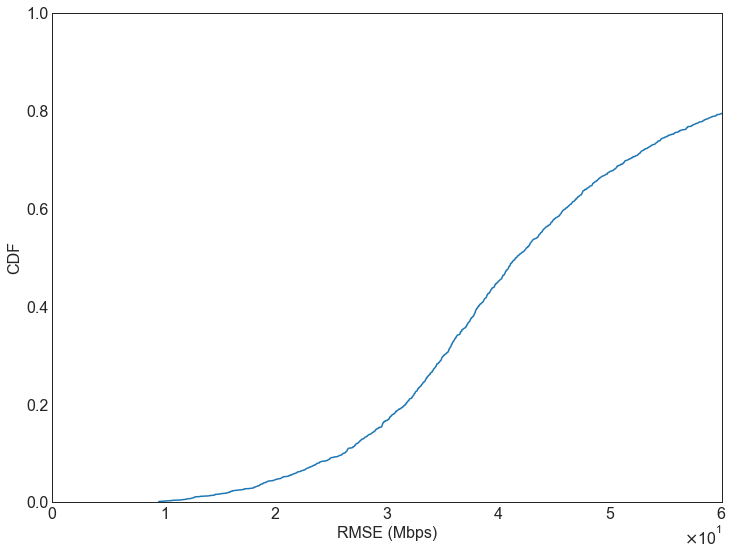

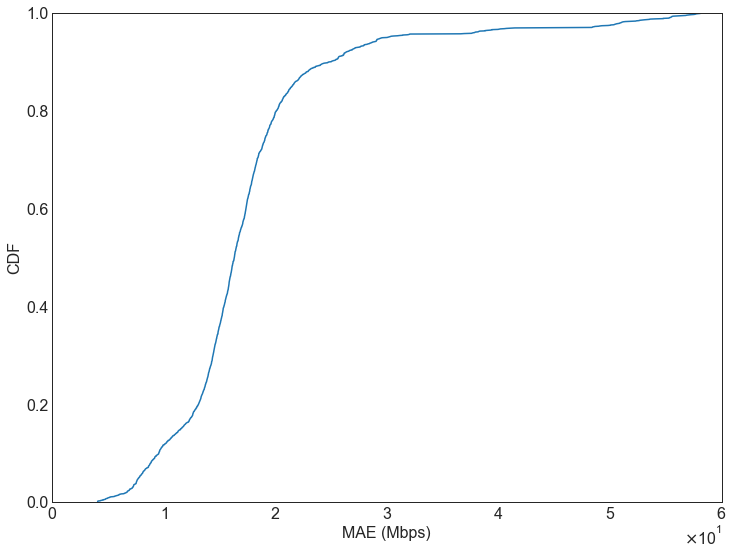

In [91]:
for step in range(horizon):
    fn = RMSE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_RMSE(y_true[:, step, :], y_pred[:, step, :], fn)
    
    fn = MAE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_MAE(y_true[:, step, :], y_pred[:, step, :], fn)